In [2]:
%load_ext autoreload
%autoreload 2

import glob, h5py, math, time, os, json
from scipy.stats import norm, expon, chi2, uniform, chisquare, gamma
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

import sys  
sys.path.insert(1, '../utils/')
import new_nplm as nplm
from ANALYSISutils import plot_2distribution

sys.path.append("../../utils/")
from plotting import make_corner

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# hyper parameters of the NPLM model
M=100 # number of kernels
flk_sigmas = [0.1, 1.5, 2.6, 3.6, 4.9, 9.8] # values of kernel's width used for multiple testing

# files containing the toys for different physics assumptions
# keep 'ref' as key for the calibraiton toys for consistence
base_dir = "/n/home11/sambt/phlab-neurips25/nplm/experiments_output/jetclass_T0.1/M100_lam1e-07_iter10000000_sigma0.1-1.5-2.6-3.6-4.9-9.8-_NoPois/"
files_dict = {
    #'ref': f"{base_dir}/Nref8000_Nbkg1000_refOnly/tests_all.h5",
    'ref': f"{base_dir}/Nref100000_Nbkg20000/tests_all.h5",
    0.001: f"{base_dir}/Nref100000_Nbkg20000_Nsig20/tests_all.h5",
    0.005: f"{base_dir}/Nref100000_Nbkg20000_Nsig100/tests_all.h5",
    0.01: f"{base_dir}/Nref100000_Nbkg20000_Nsig200/tests_all.h5",
    0.02: f"{base_dir}/Nref100000_Nbkg20000_Nsig400/tests_all.h5",
    0.05: f"{base_dir}/Nref100000_Nbkg20000_Nsig1000/tests_all.h5",
}
# key values extraction
files = list(files_dict.values())
labels_list = list(files_dict.keys())
inj_fractions = sorted([k for k in files_dict.keys() if k != 'ref'])

# plot Z scores

In [6]:
NTOYS = 500

tstat_dict = {}
i=0
for f5 in files:
    f = h5py.File(f5, 'r')
    if not len(flk_sigmas):
        flk_sigmas = list(f.keys())
    tstat_dict[labels_list[i]] = []
    for flk_sigma in flk_sigmas:
        key = str(flk_sigma) 
        tstat_dict[labels_list[i]].append(np.array(f[key])[:NTOYS].reshape(-1,1))
    tstat_dict[labels_list[i]] = np.concatenate(tstat_dict[labels_list[i]],axis=1)
    f.close()
    i+=1

pvalues = {}
pvalues_min = {}
pvalues_avg = {}
pvalues_prod = {}
z_obs = {}
z_obs_p = {}
z_obs_m = {}
z_emp = {}
z_emp_p = {}
z_emp_m = {}
z_min = {}
z_avg = {}
z_prod = {}
i=0
for key in list(tstat_dict.keys()):
    pvalues[key] = []
    z_obs[key] = []
    z_obs_p[key] = []
    z_obs_m[key] = []
    z_emp[key] = []
    z_emp_p[key] = []
    z_emp_m[key] = []
    for isigma,flk_sigma in enumerate(flk_sigmas):
        t1 = tstat_dict['ref'][:,isigma]
        t1[np.isnan(t1)]=np.zeros_like(t1[np.isnan(t1)])
        
        t2 = tstat_dict[key][:,isigma]
        t2[np.isnan(t2)]=np.zeros_like(t2[np.isnan(t2)])
        
        z_obs_val, z_emp_val = nplm.get_zScores(t1, t2, df=np.mean(t1))
                
        pvalues[key].append(chi2.sf(t2, df=np.median(t1)).reshape(-1,1))
        
        z_obs[key].append(np.array([z_obs_val[0]]).reshape(1,1))
        z_obs_p[key].append(np.array([z_obs_val[1]]).reshape(1,1))
        z_obs_m[key].append(np.array([z_obs_val[2]]).reshape(1,1))
        
        z_emp[key].append(np.array([z_emp_val[0]]).reshape(1,1))
        z_emp_p[key].append(np.array([z_emp_val[1]]).reshape(1,1))
        z_emp_m[key].append(np.array([z_emp_val[2]]).reshape(1,1))
        
    i+=1
    pvalues[key] = np.concatenate(pvalues[key],axis=1)
    z_obs[key] = np.concatenate(z_obs[key],axis=1)
    z_obs_p[key] = np.concatenate(z_obs_p[key],axis=1)
    z_obs_m[key] = np.concatenate(z_obs_m[key],axis=1)
    z_emp[key] = np.concatenate(z_emp[key],axis=1)
    z_emp_p[key] = np.concatenate(z_emp_p[key],axis=1)
    z_emp_m[key] = np.concatenate(z_emp_m[key],axis=1)
    
    # compute mins/prods/means over all kernel sizes
    t1 = tstat_dict['ref']
    t1[np.isnan(t1)]=np.zeros_like(t1[np.isnan(t1)])
    t2 = tstat_dict[key]
    t2[np.isnan(t2)]=np.zeros_like(t2[np.isnan(t2)])
    
    p_min_ref, p_min_data = nplm.NPLM_combined_pval(t1,t2,rule='min')
    p_avg_ref, p_avg_data = nplm.NPLM_combined_pval(t1,t2,rule='avg')
    p_prod_ref, p_prod_data = nplm.NPLM_combined_pval(t1,t2,rule='prod')
    
    pvalues_min[key] = p_min_data
    pvalues_avg[key] = p_avg_data
    pvalues_prod[key] = p_prod_data
    
    z_min[key] = nplm.z_emp(p_min_ref,p_min_data)
    z_avg[key] = nplm.z_emp(p_avg_ref,p_avg_data)
    z_prod[key] = nplm.z_emp(p_prod_ref,p_prod_data)

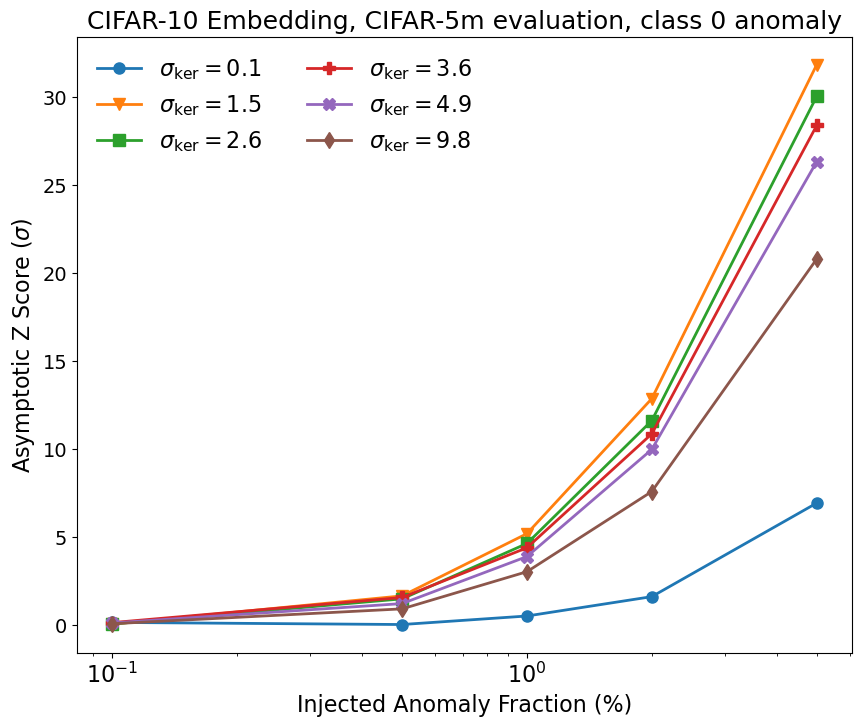

In [7]:
plt.figure(figsize=(10,8))
plt.title("CIFAR-10 Embedding, CIFAR-5m evaluation, class 0 anomaly",fontsize=18)
x_values = [100*f for f in inj_fractions]
markers = ['o','v','s','P','X','d']
for isigma,sigma in enumerate(flk_sigmas):
    y_values = [z_obs[f][:,isigma] for f in inj_fractions]
    plt.plot(x_values,y_values,lw=2,
             marker=markers[isigma],markersize=8,
             color=f"C{isigma}",
             label=f"$\sigma_\\text{{ker}} = {sigma:.1f}$")
plt.xscale('log')
plt.yticks(fontsize=14)
plt.xticks(fontsize=16)
plt.ylabel("Asymptotic Z Score ($\sigma$)",fontsize=16)
plt.xlabel("Injected Anomaly Fraction (%)",fontsize=16)
plt.legend(ncol=2,fontsize=16,frameon=False)

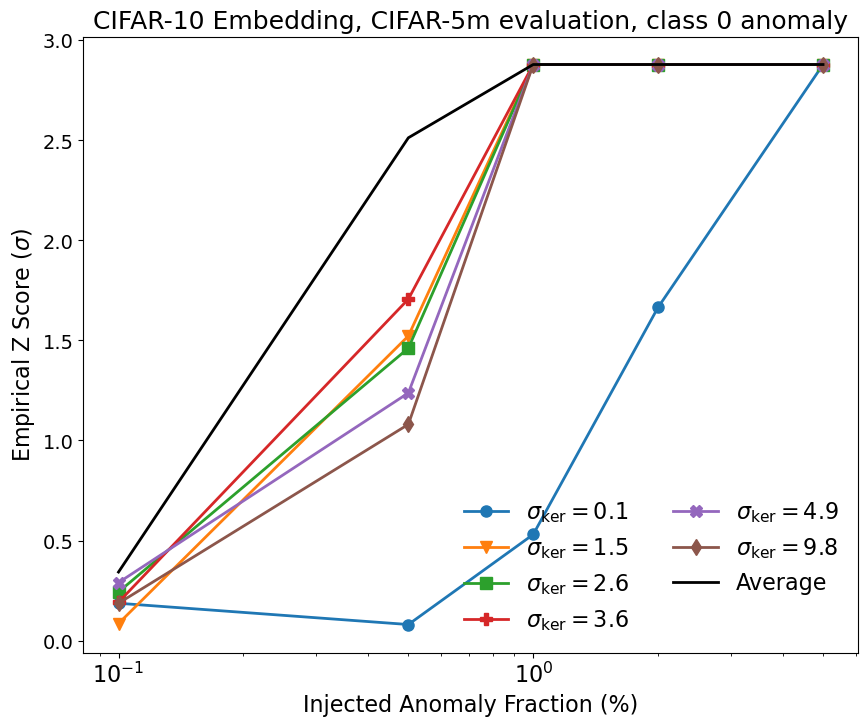

In [8]:
plt.figure(figsize=(10,8))
plt.title("CIFAR-10 Embedding, CIFAR-5m evaluation, class 0 anomaly",fontsize=18)
x_values = [100*f for f in inj_fractions]
markers = ['o','v','s','P','X','d']
for isigma,sigma in enumerate(flk_sigmas):
    y_values = [z_emp[f][:,isigma] for f in inj_fractions]
    plt.plot(x_values,y_values,lw=2,
             marker=markers[isigma],markersize=8,
             color=f"C{isigma}",
             label=f"$\sigma_\\text{{ker}} = {sigma:.1f}$")
#plt.plot(x_values,[z_min[f] for f in inj_fractions],lw=2, marker=None,color="k",label=f"Min Aggregation")
plt.plot(x_values,[z_avg[f] for f in inj_fractions],lw=2, linestyle='-',marker=None,color="k",label=f"Average")
#plt.plot(x_values,[z_prod[f] for f in inj_fractions],lw=2, linestyle='--',marker=None,color="k",label=f"Prod Aggregation")
plt.xscale('log')
plt.yticks(fontsize=14)
plt.xticks(fontsize=16)
plt.ylabel("Empirical Z Score ($\sigma$)",fontsize=16)
plt.xlabel("Injected Anomaly Fraction (%)",fontsize=16)
plt.legend(ncol=2,fontsize=16,frameon=False)

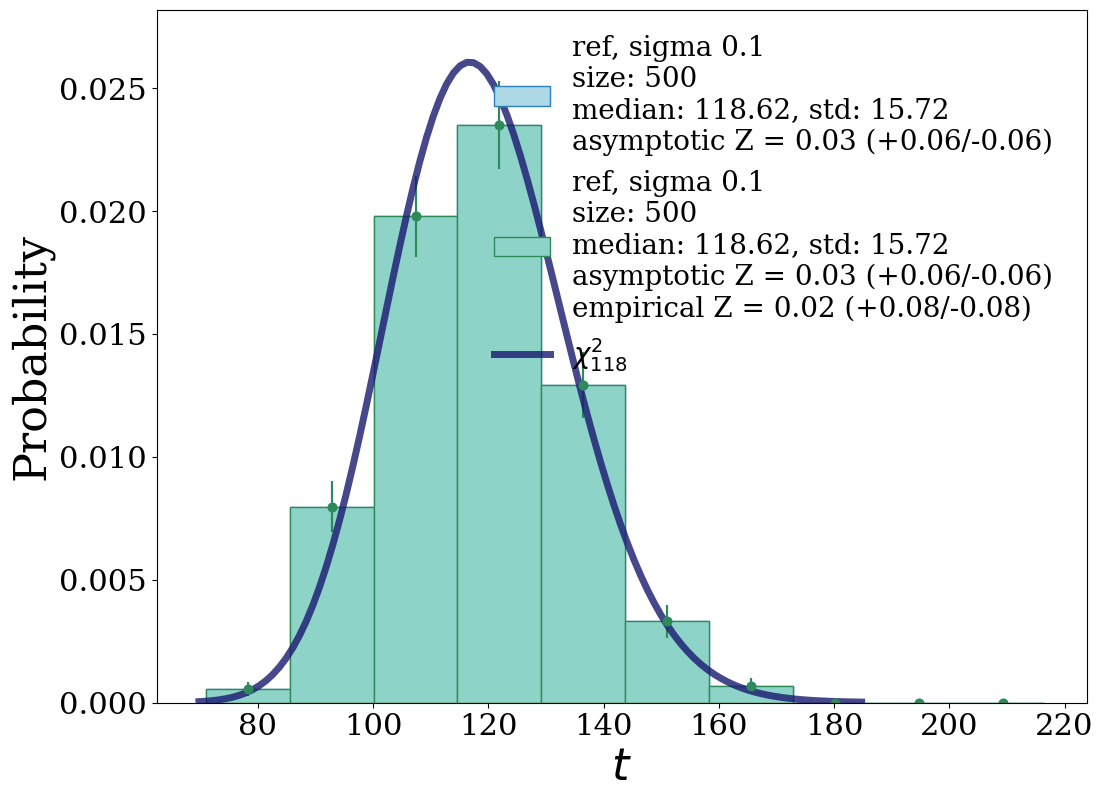

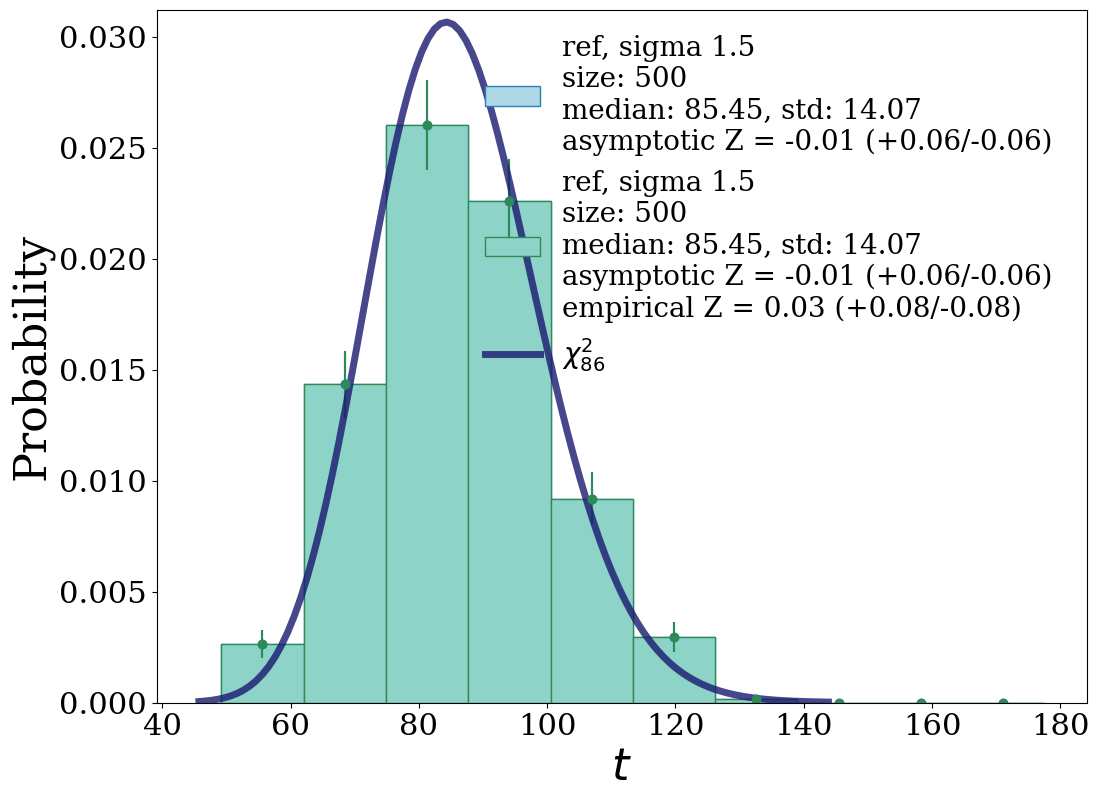

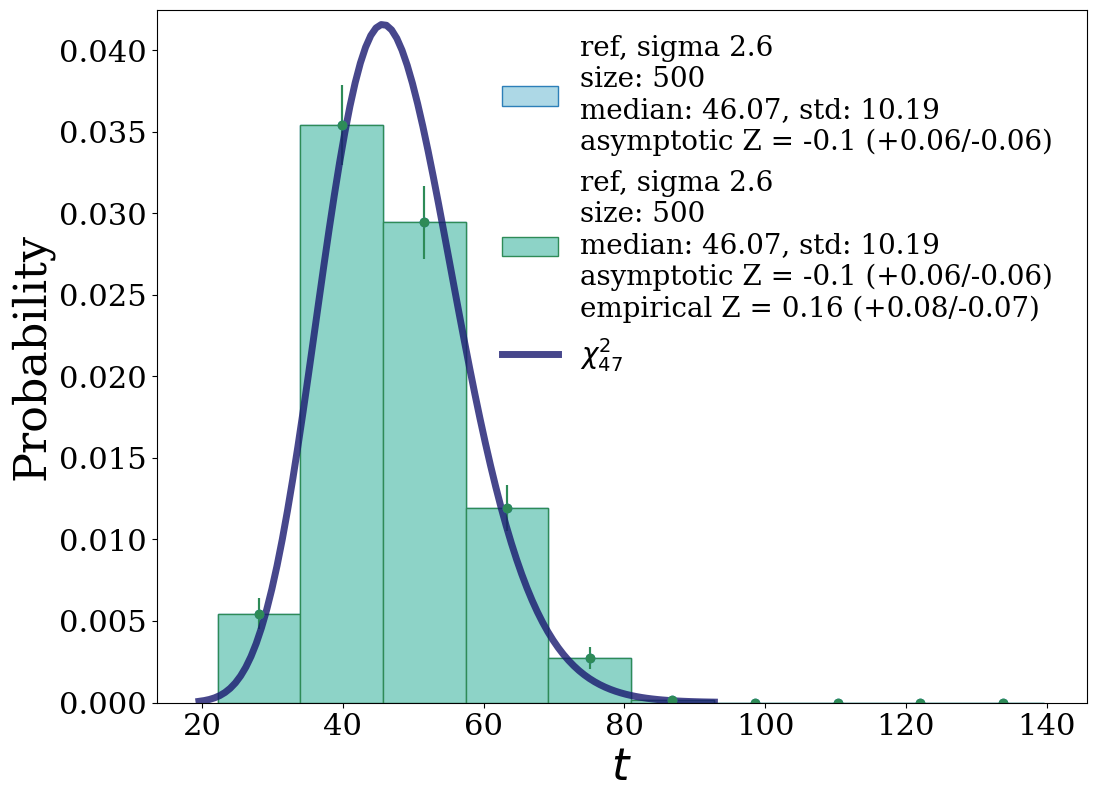

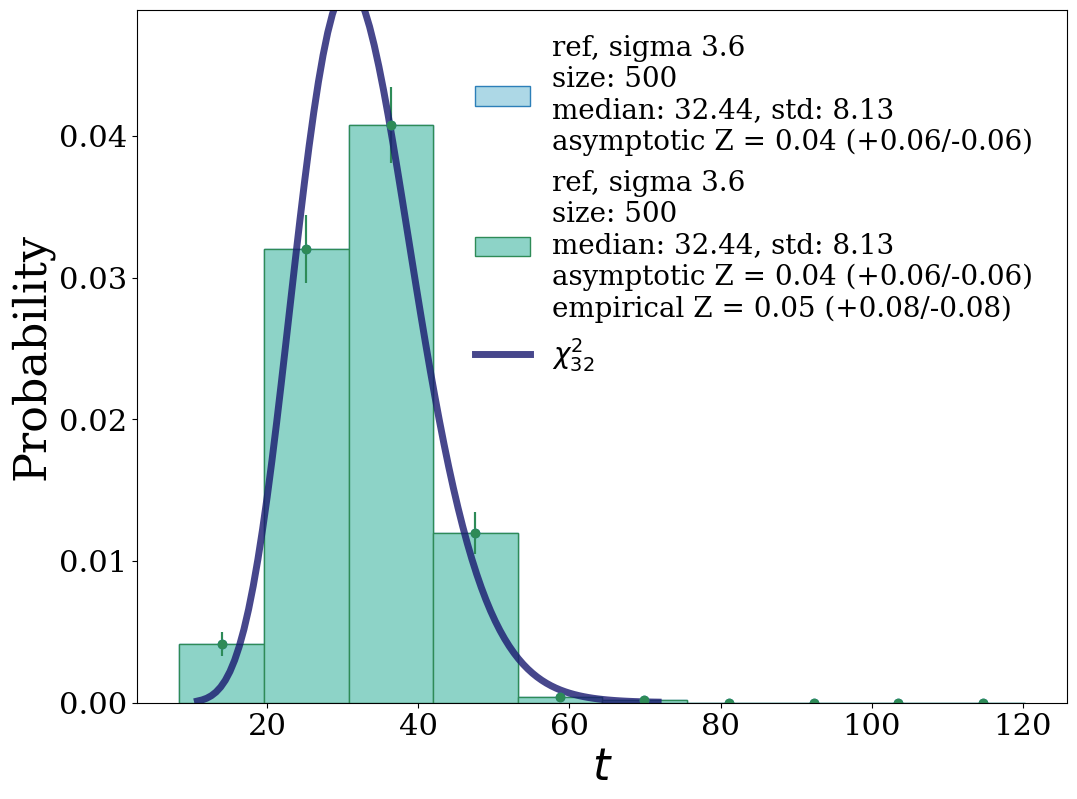

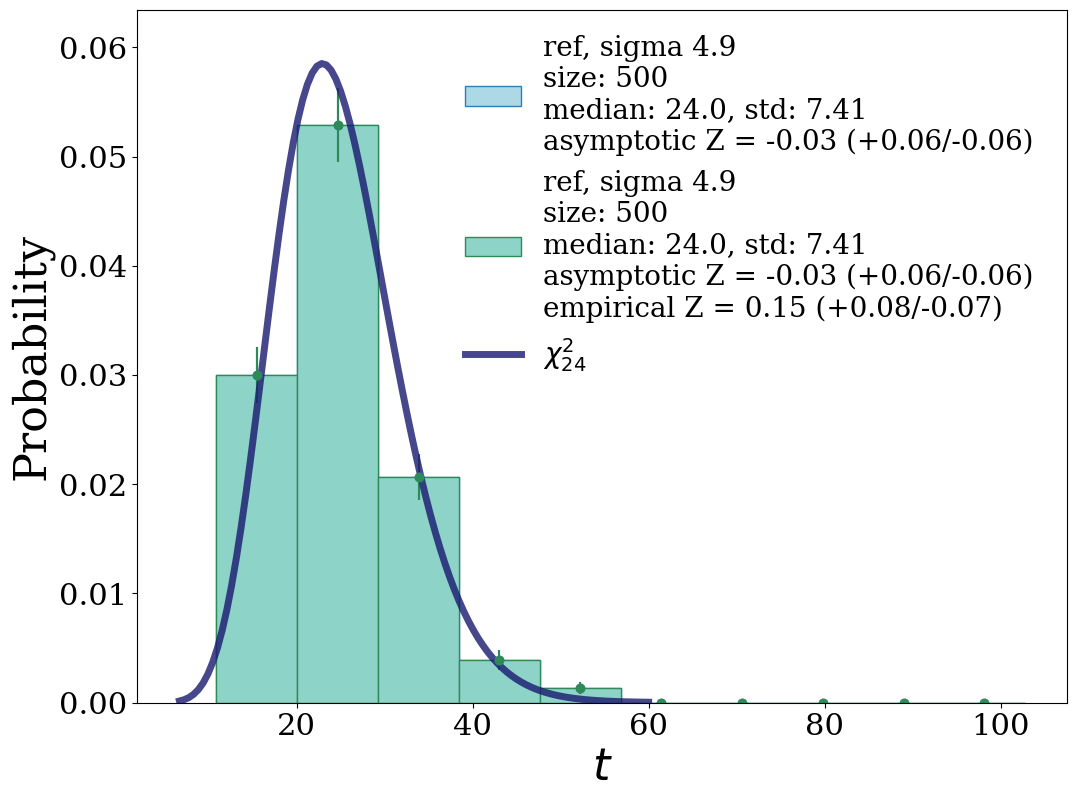

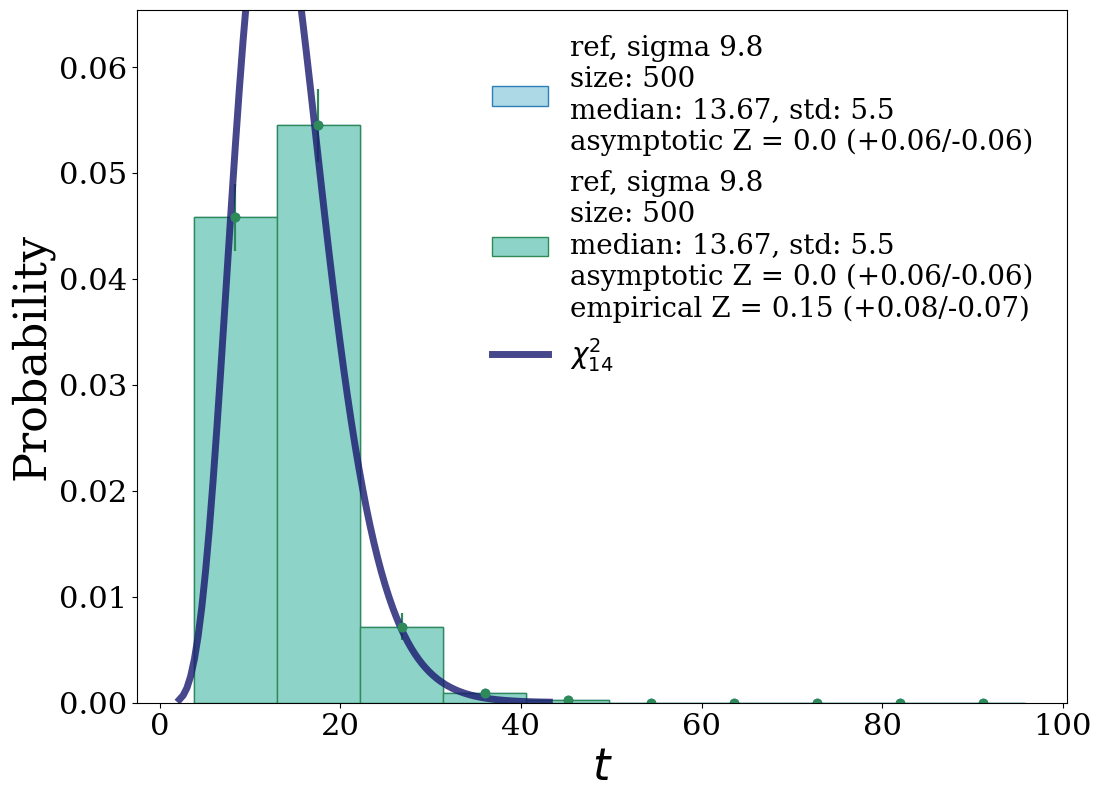

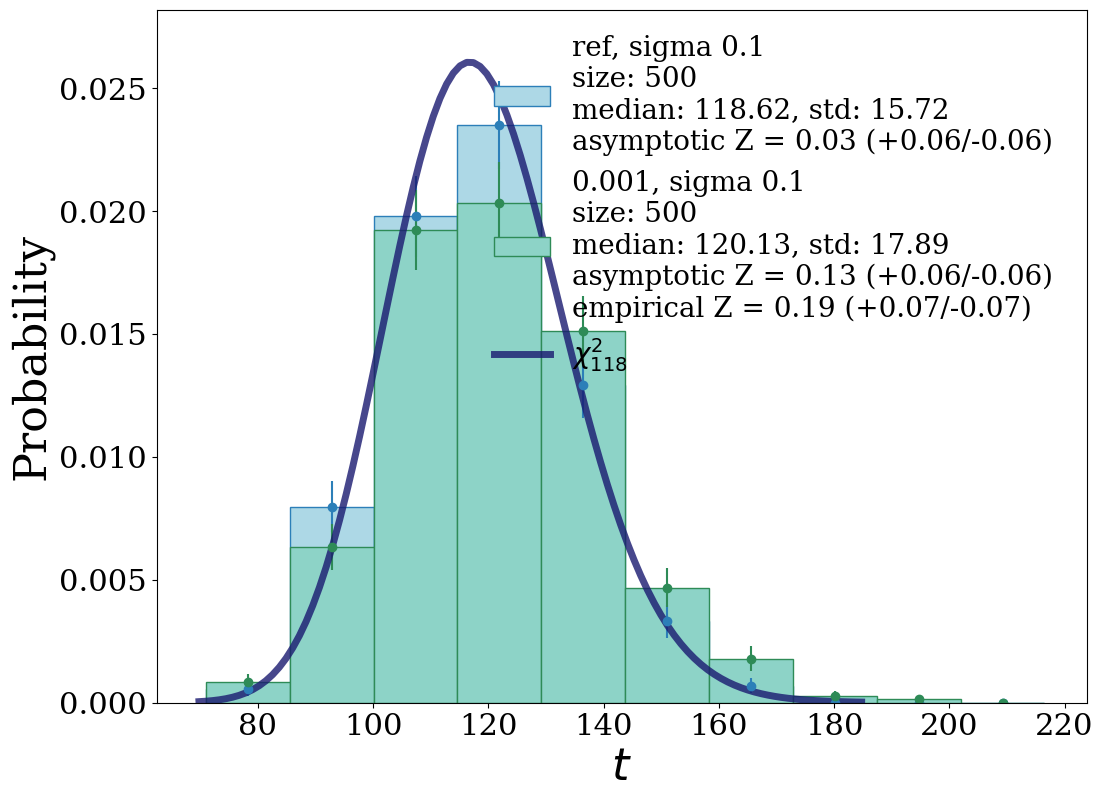

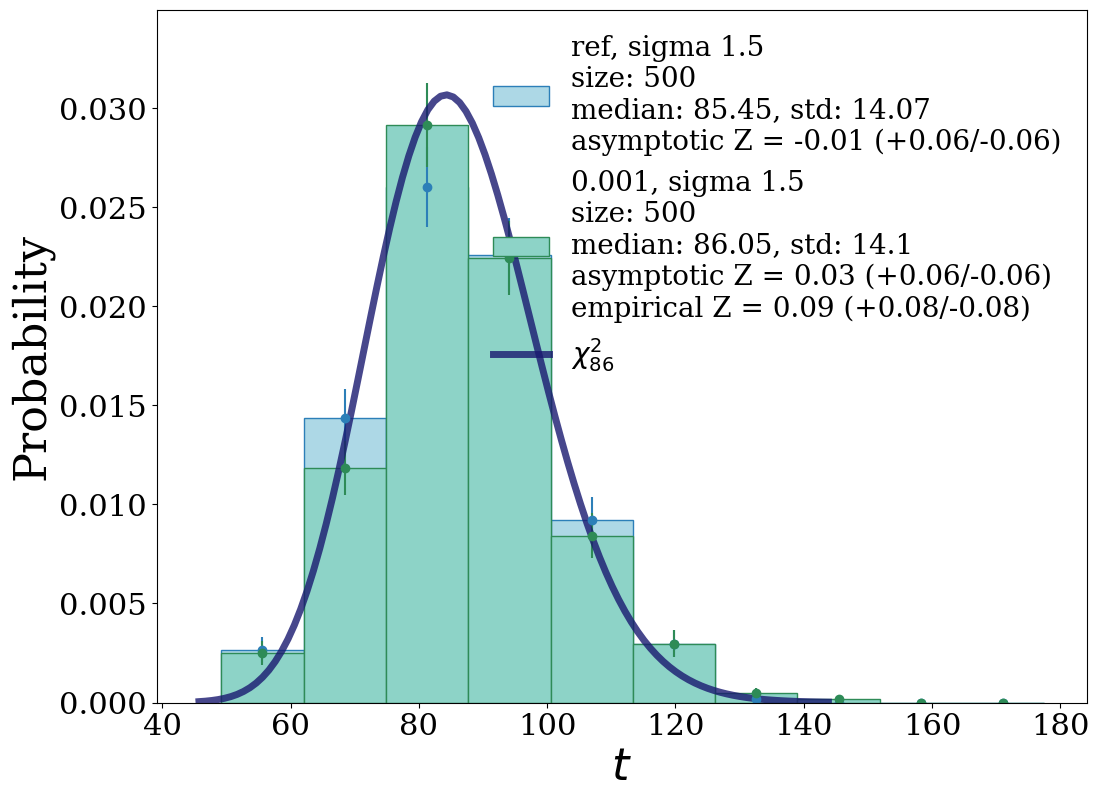

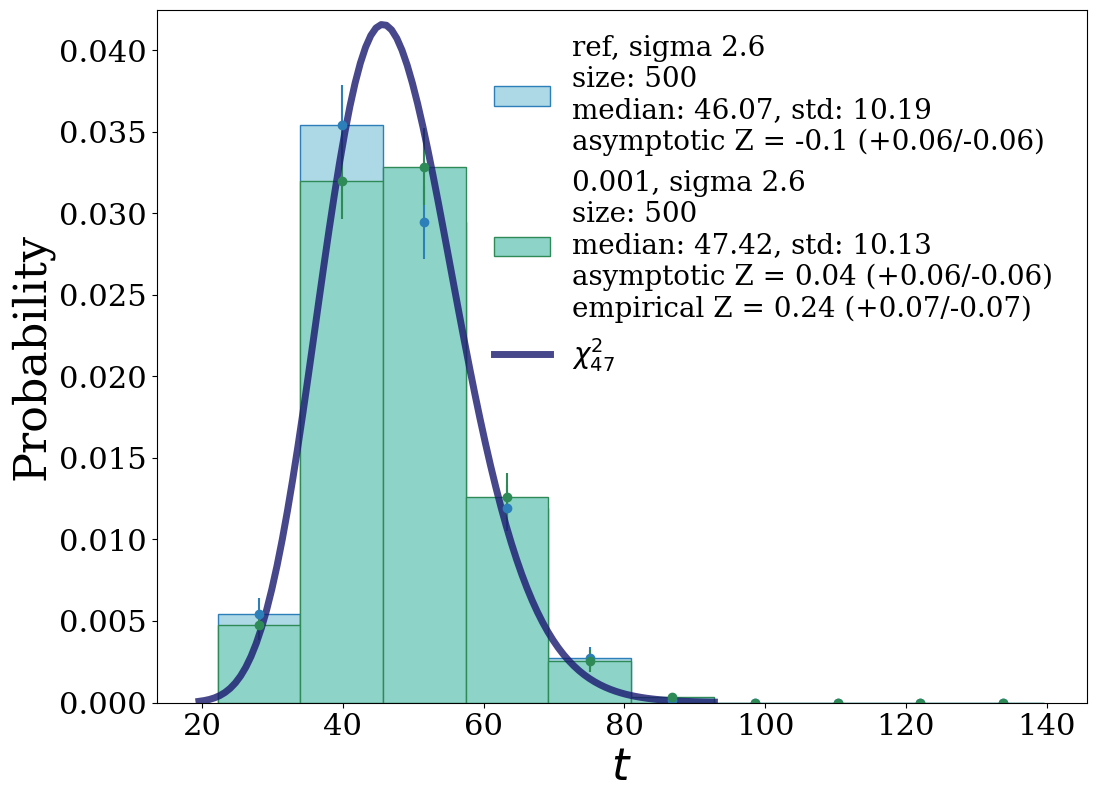

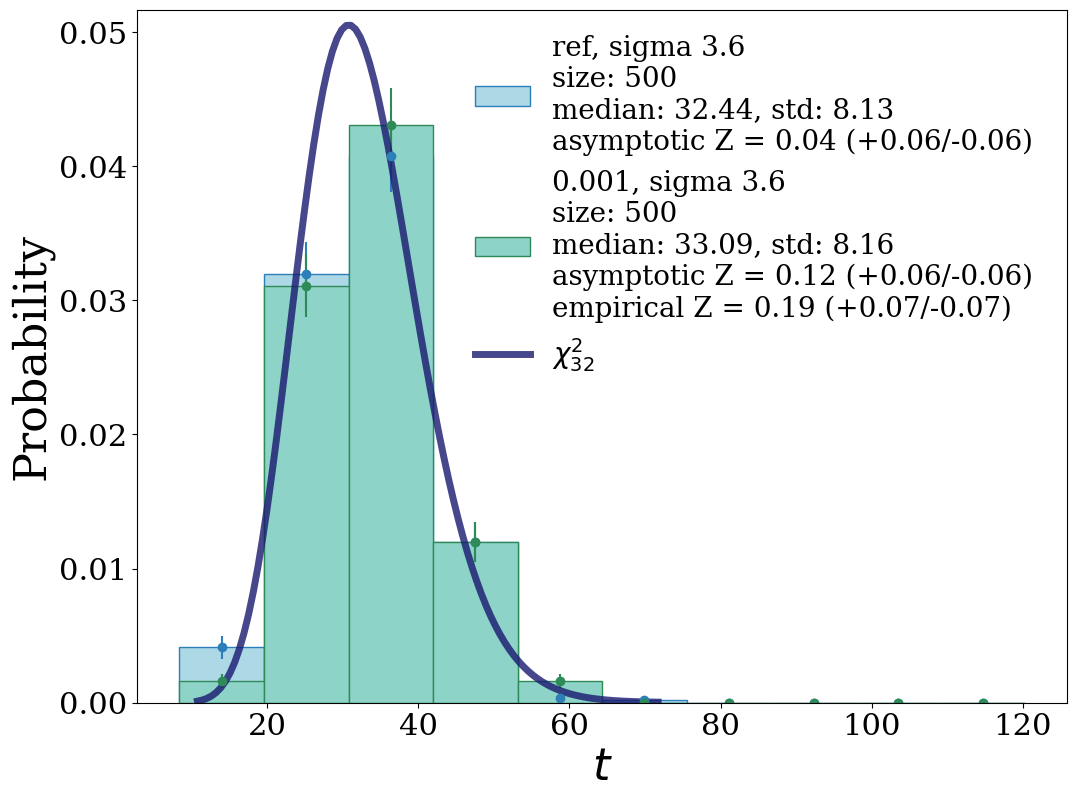

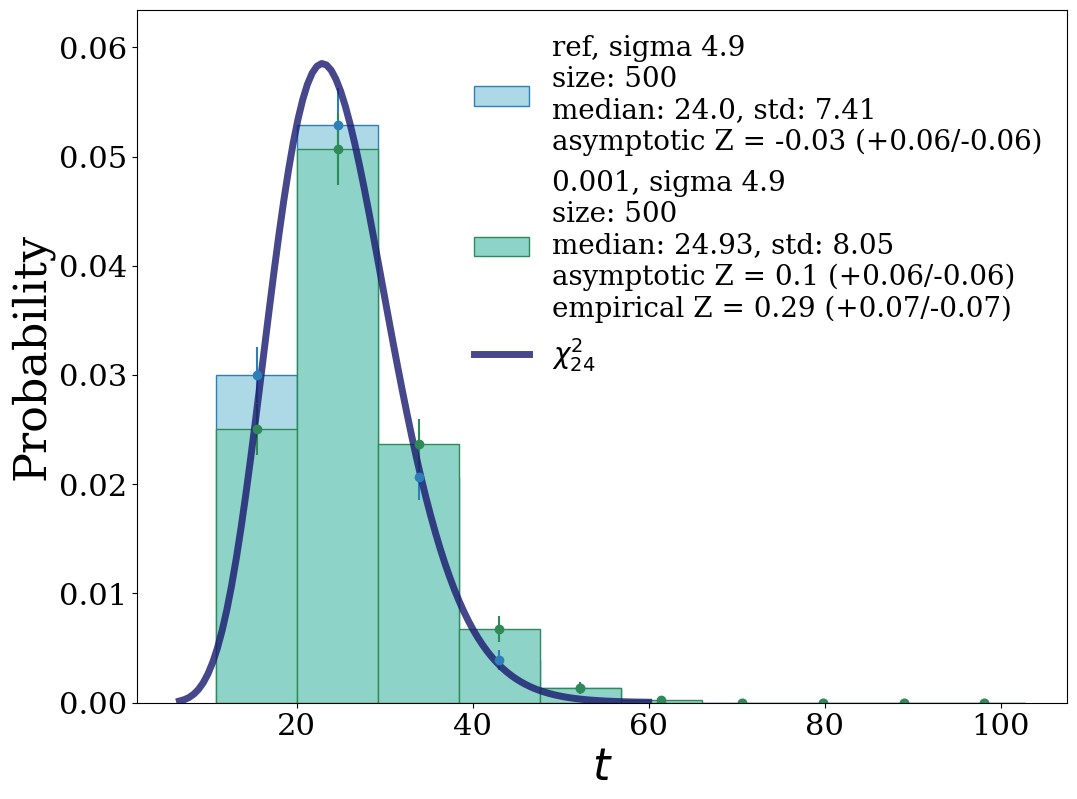

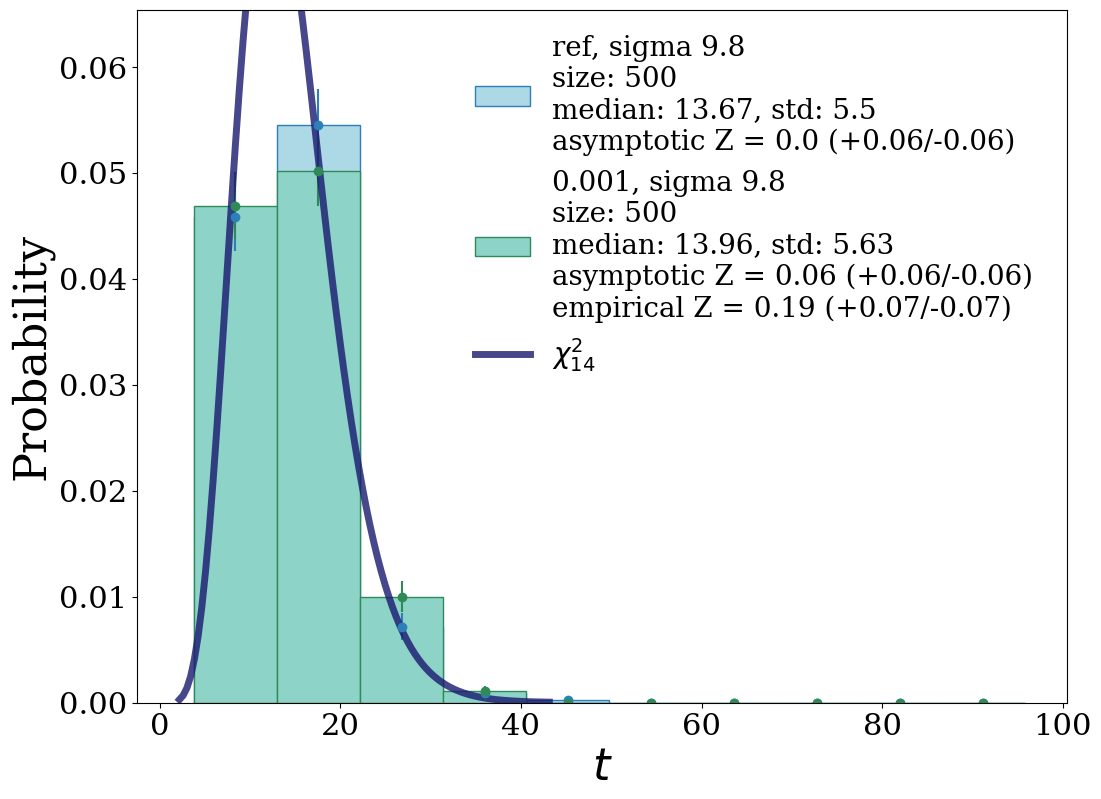

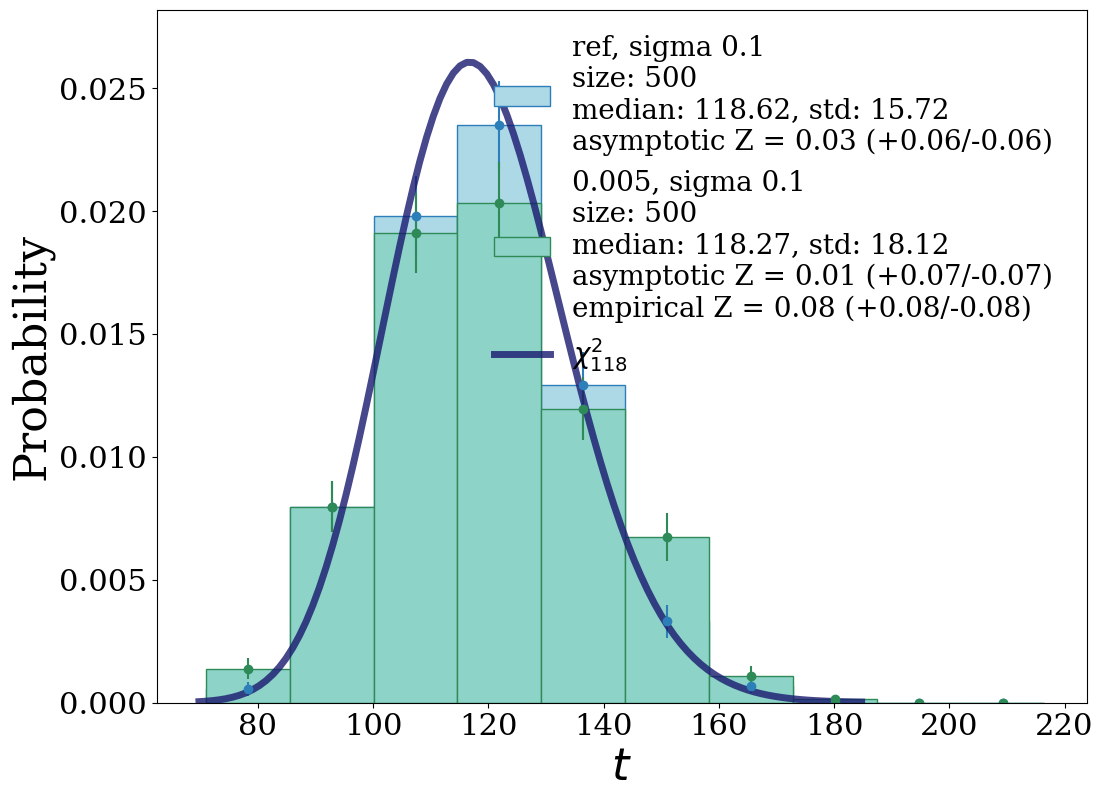

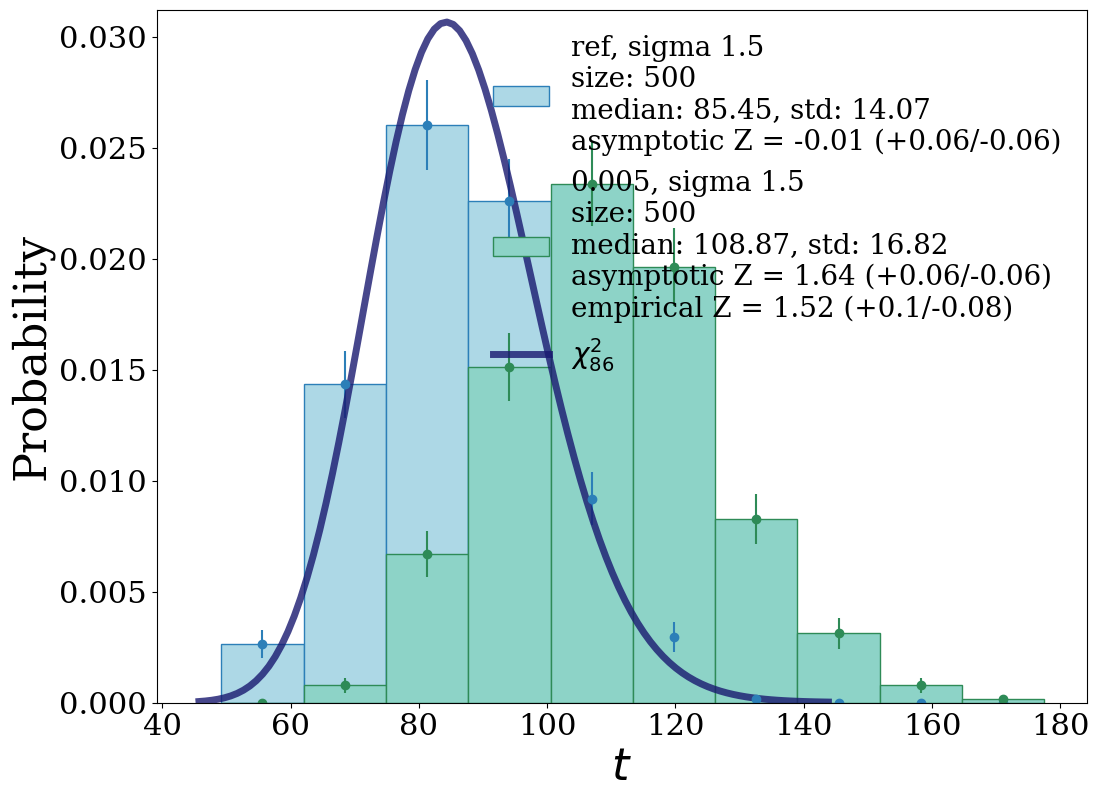

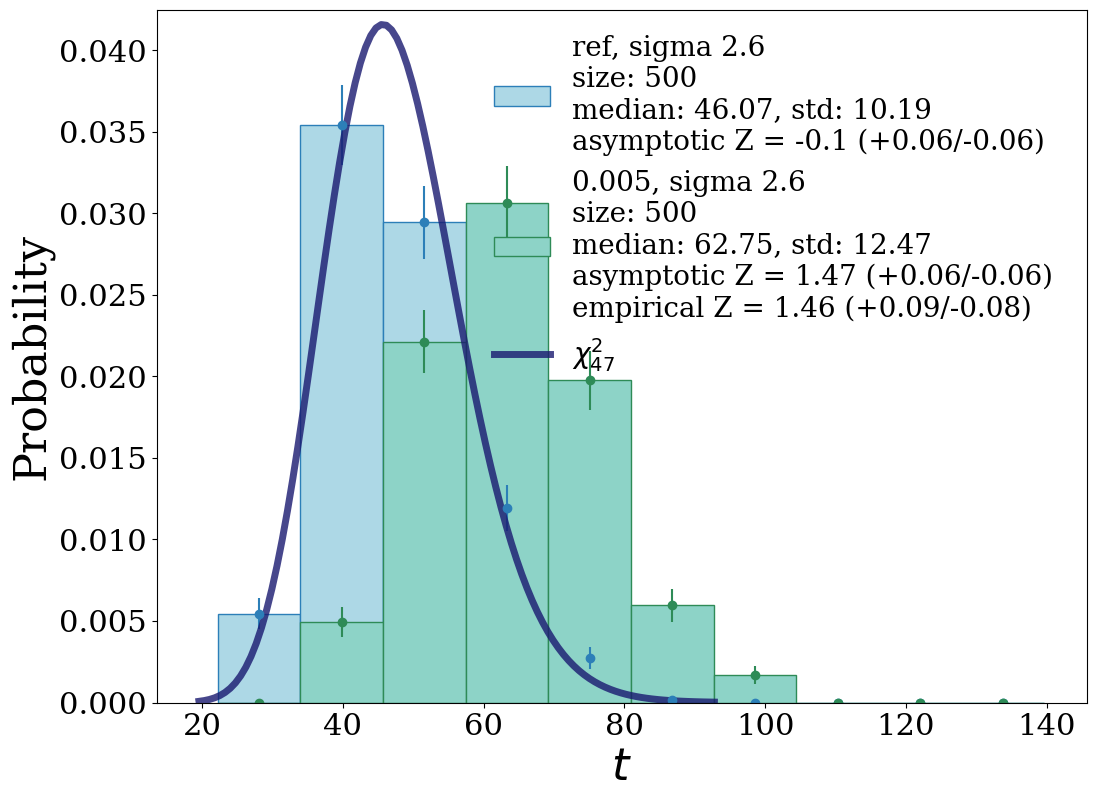

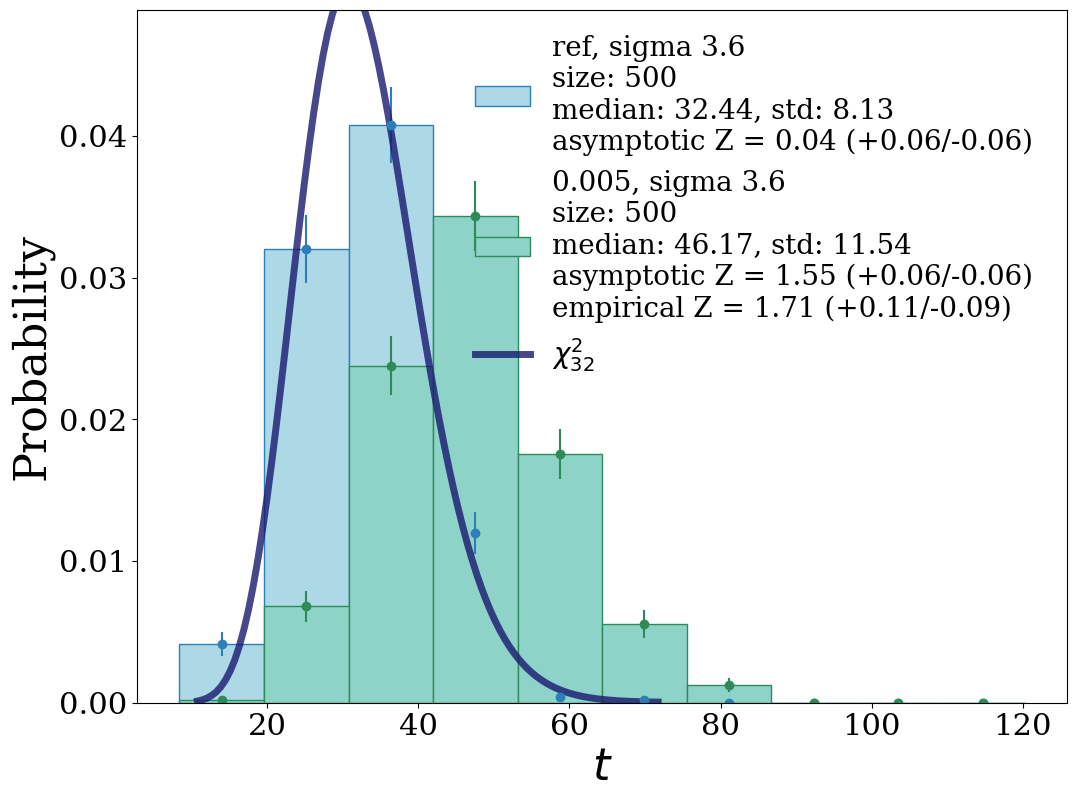

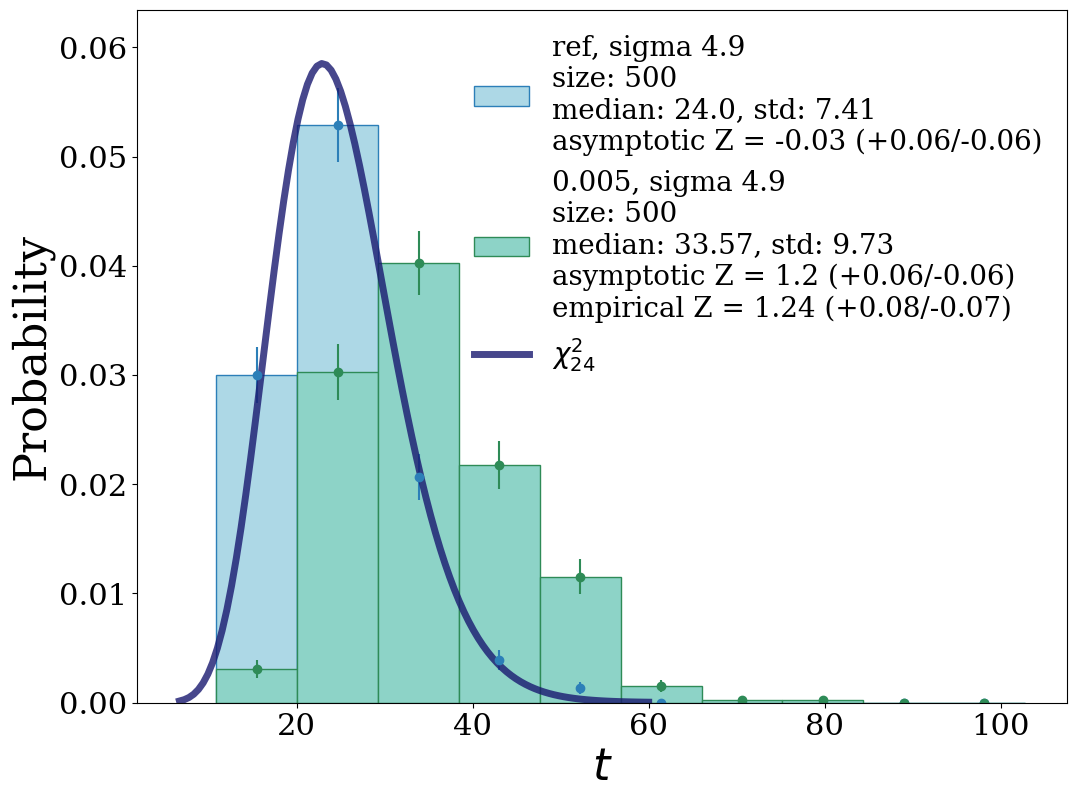

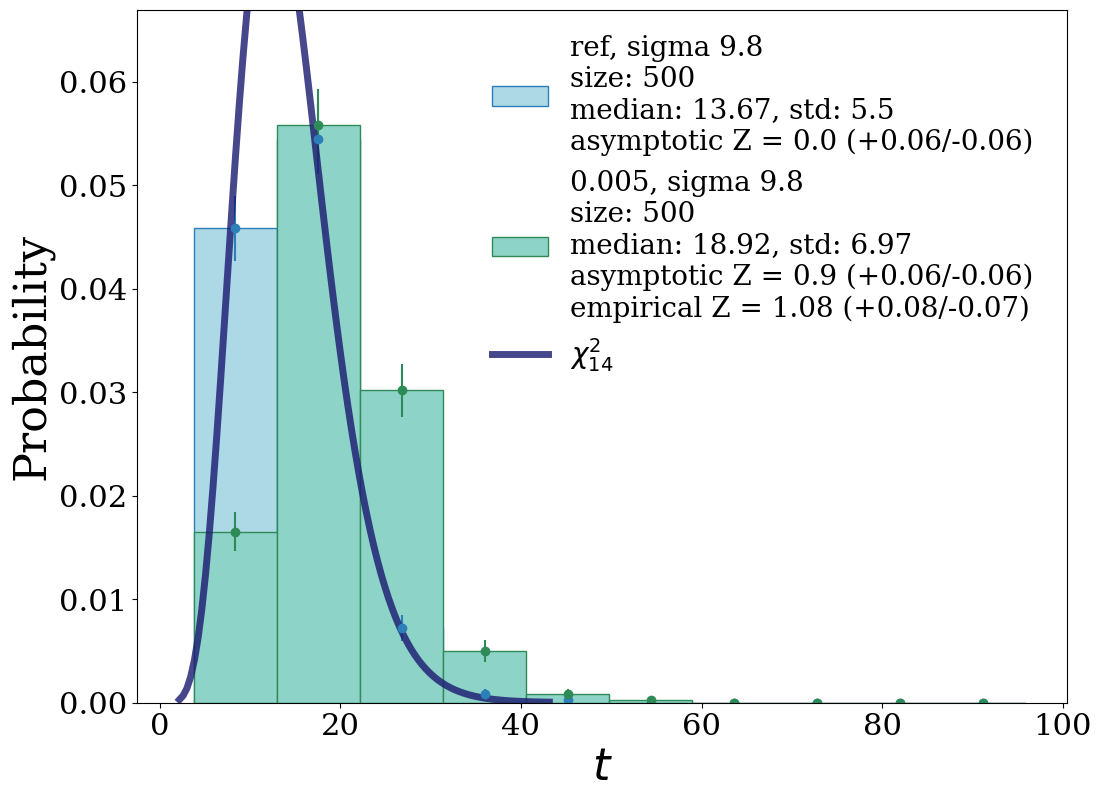

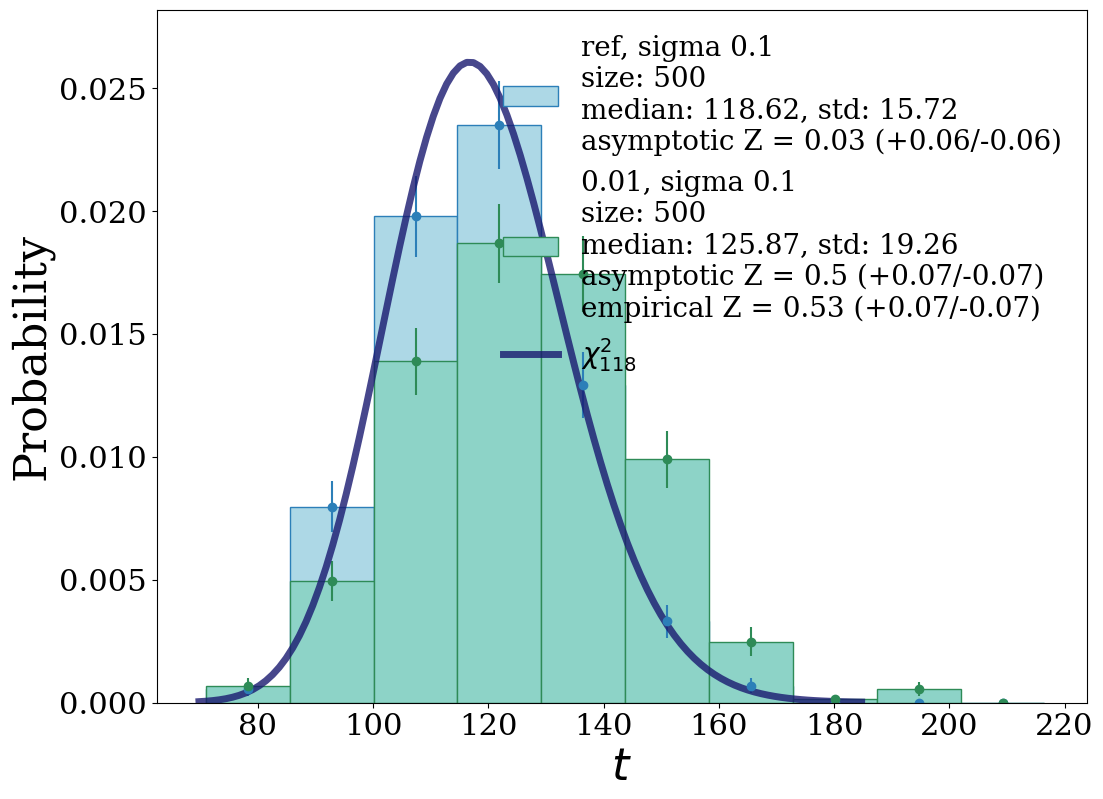

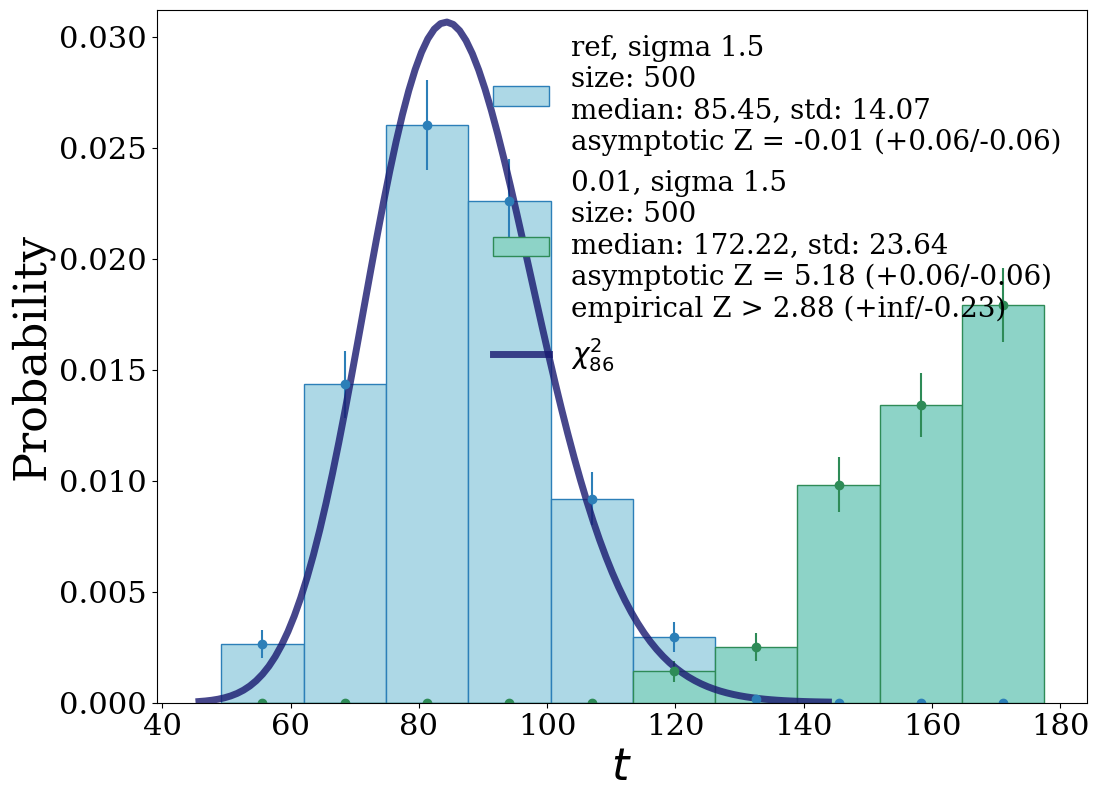

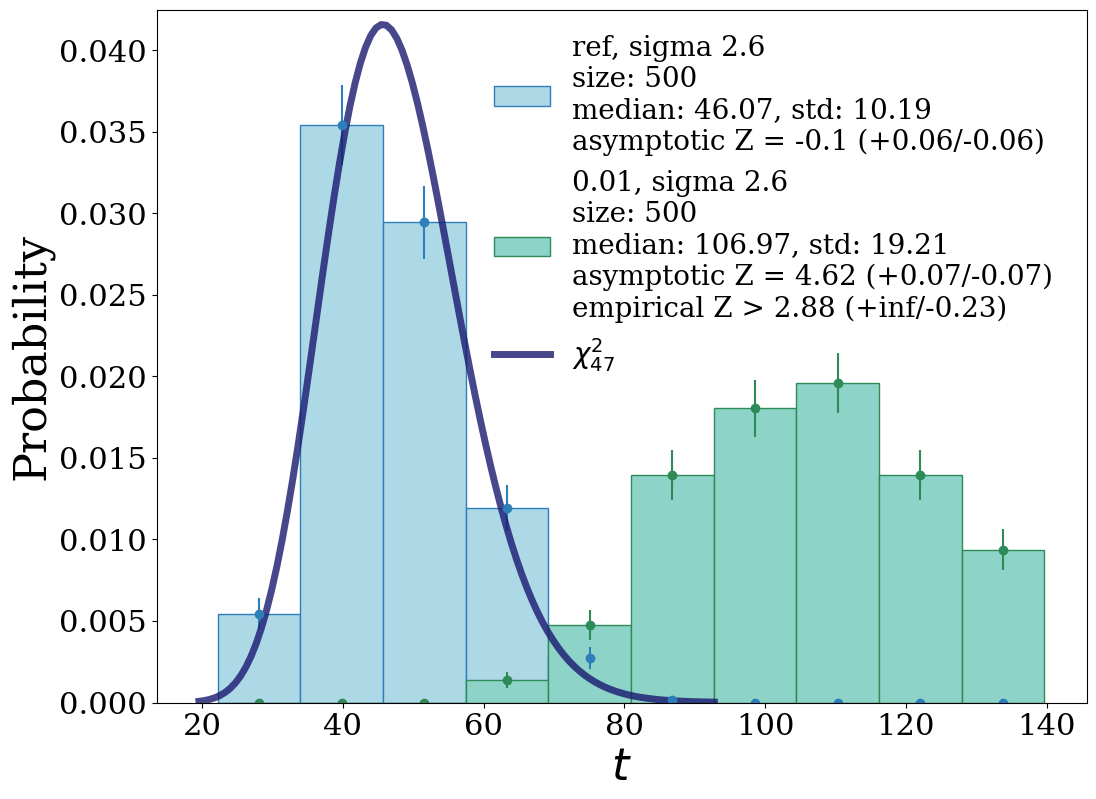

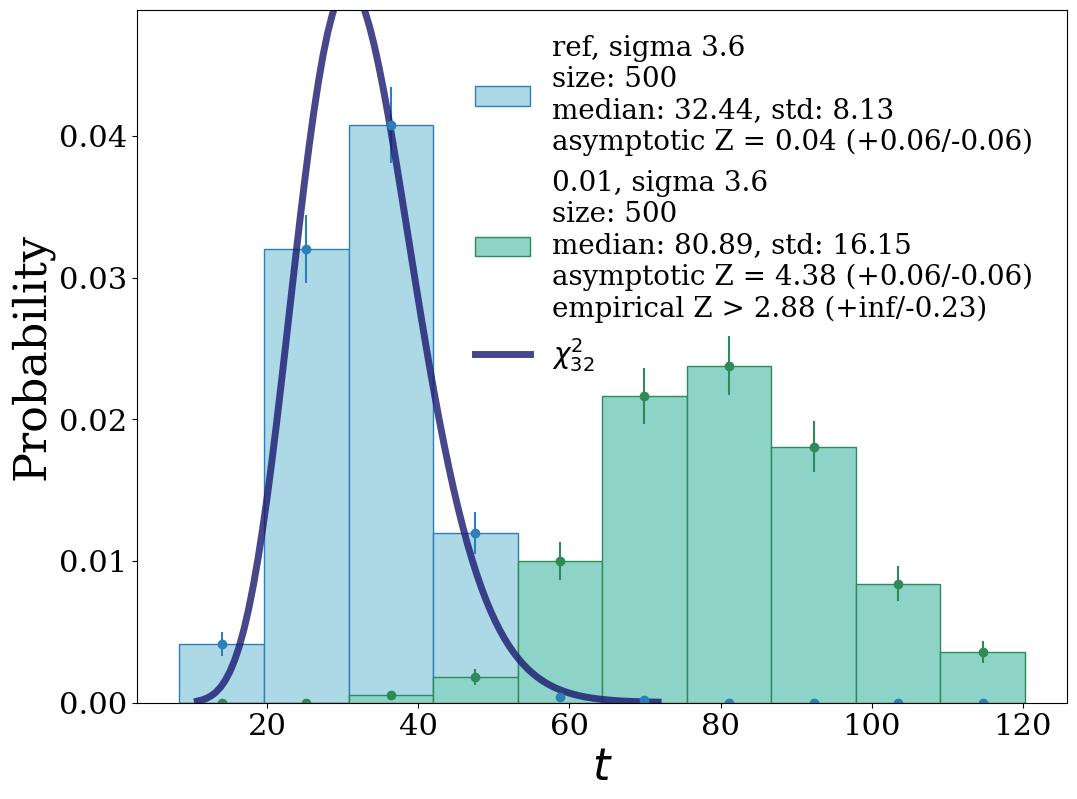

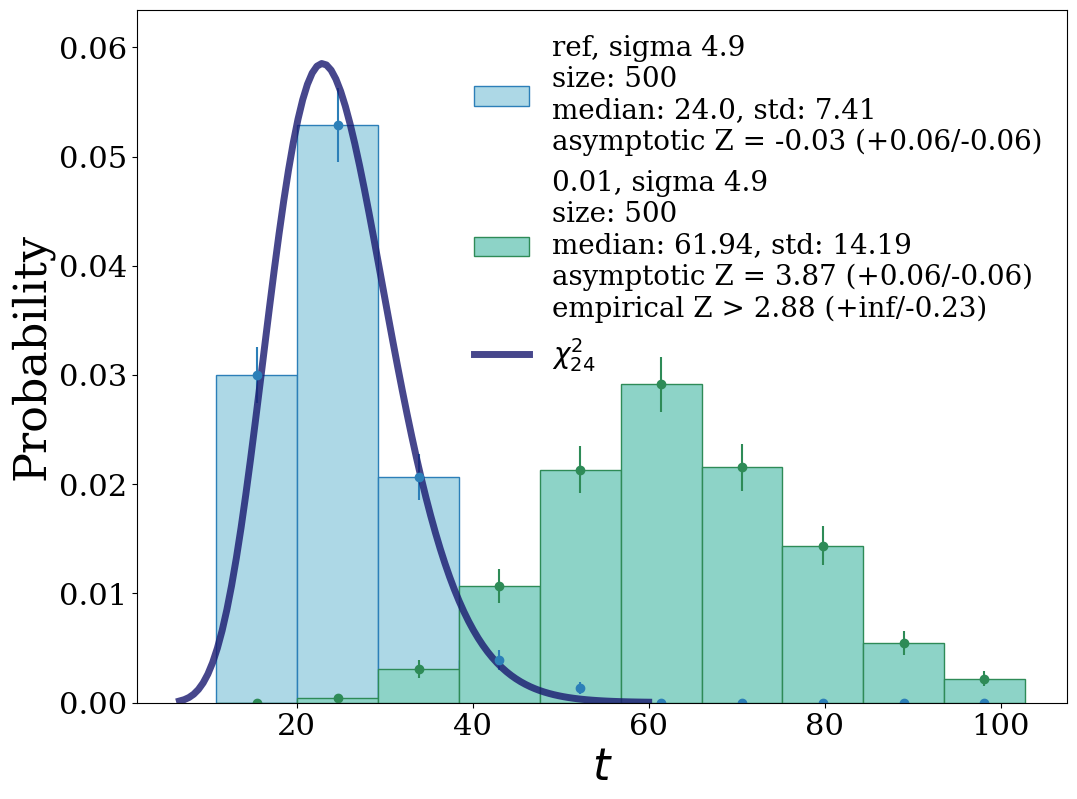

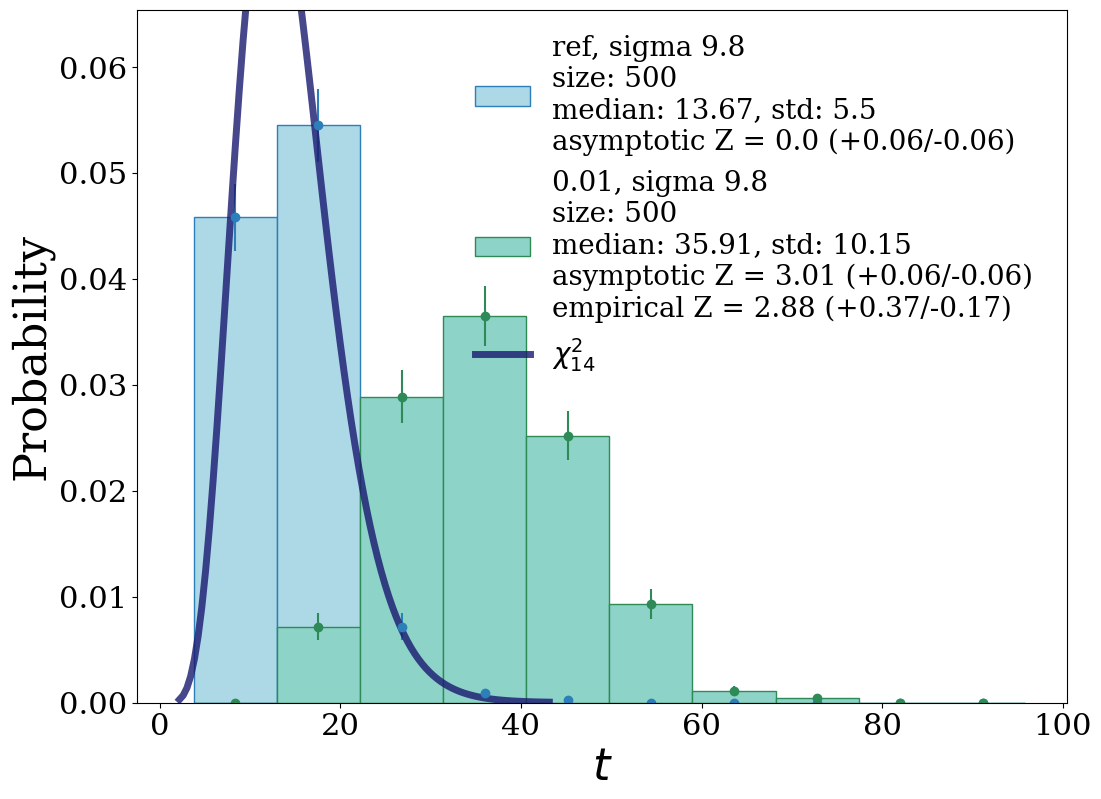

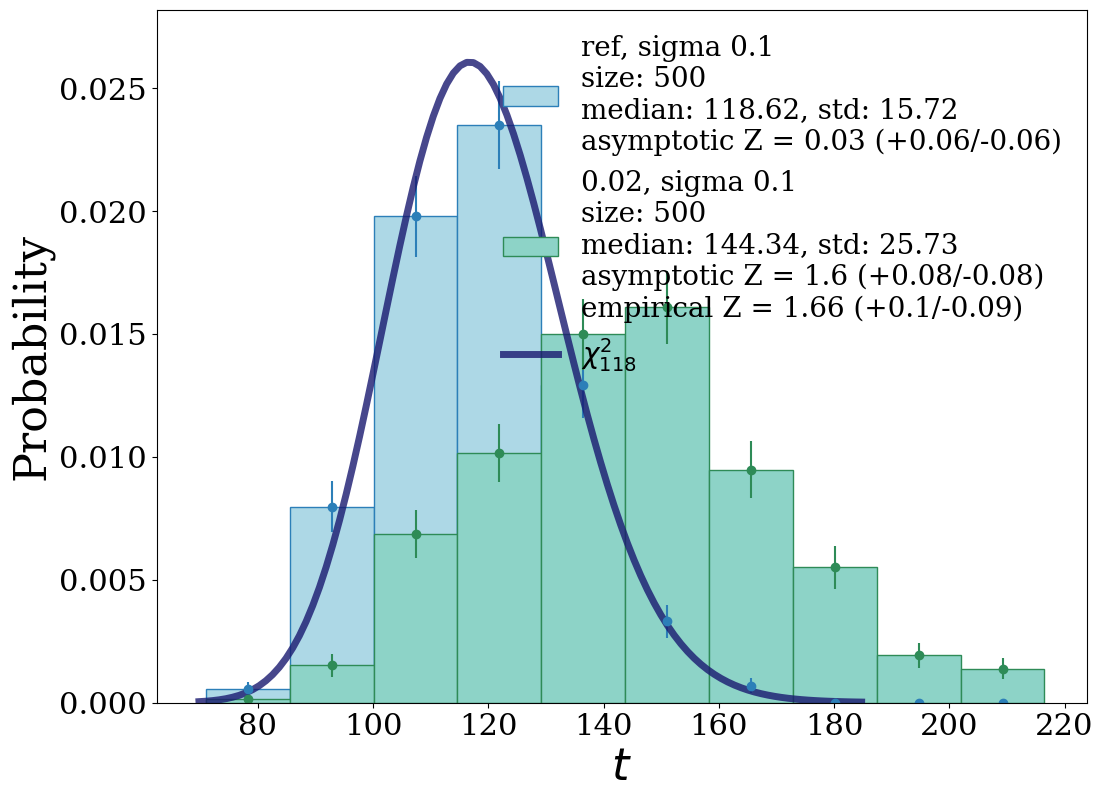

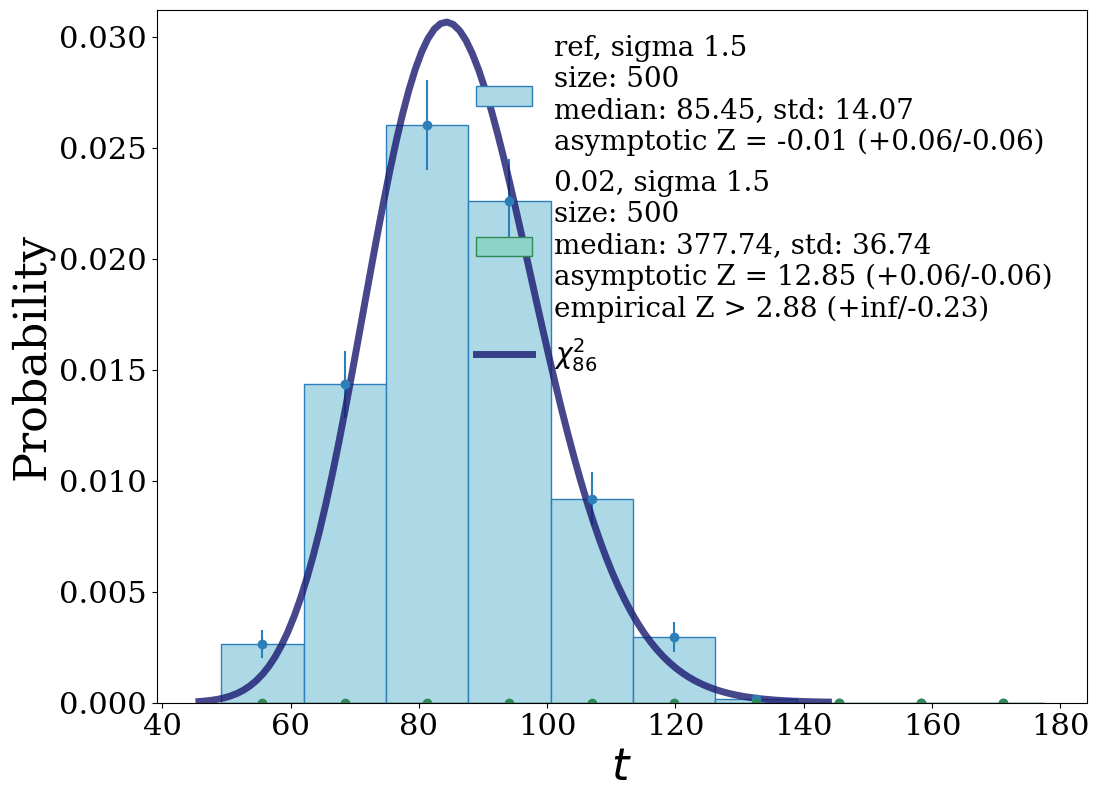

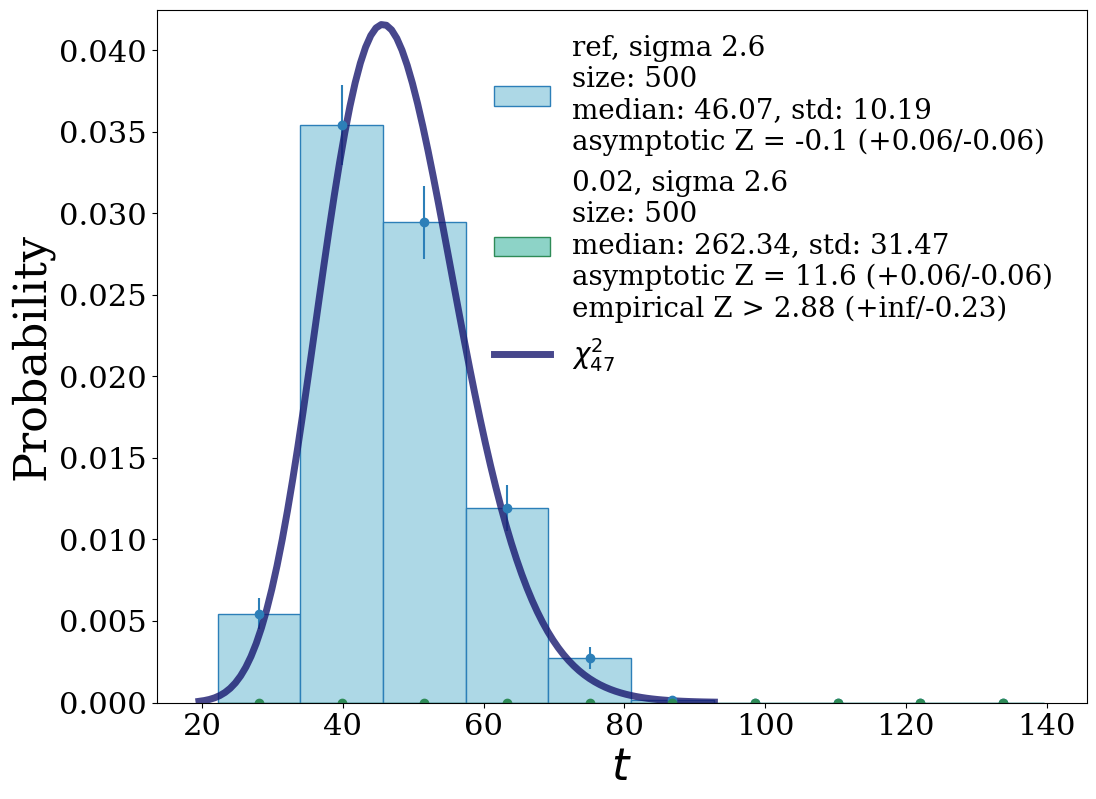

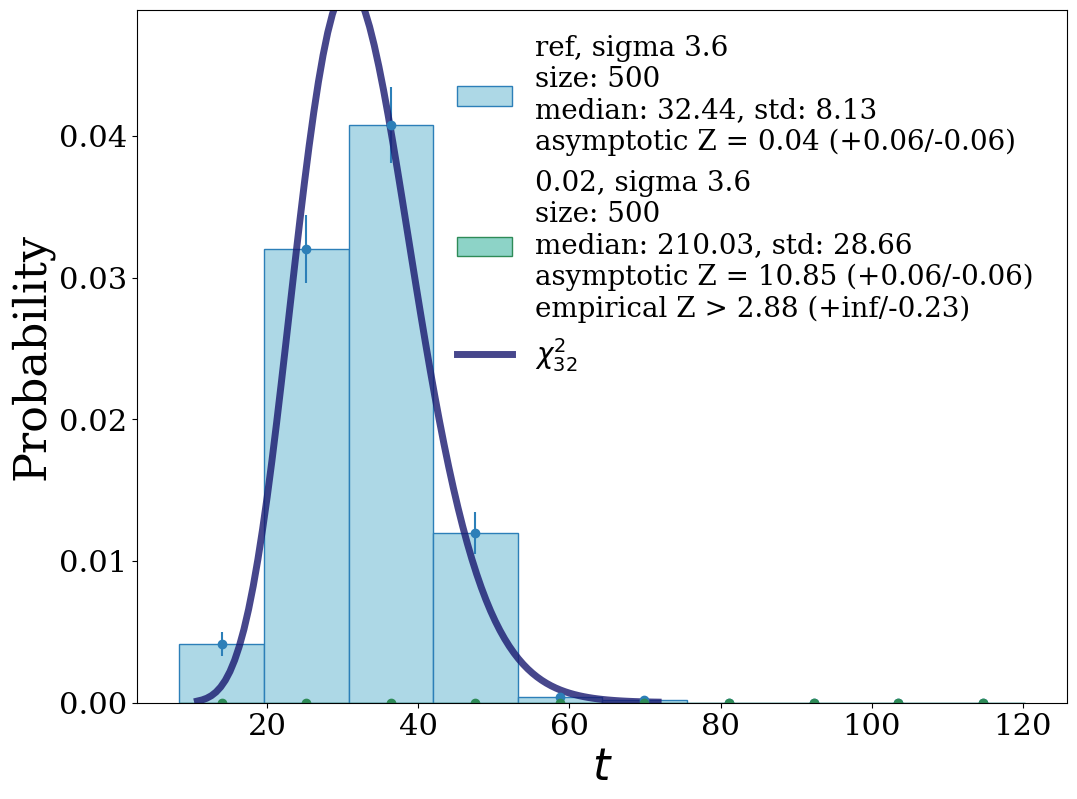

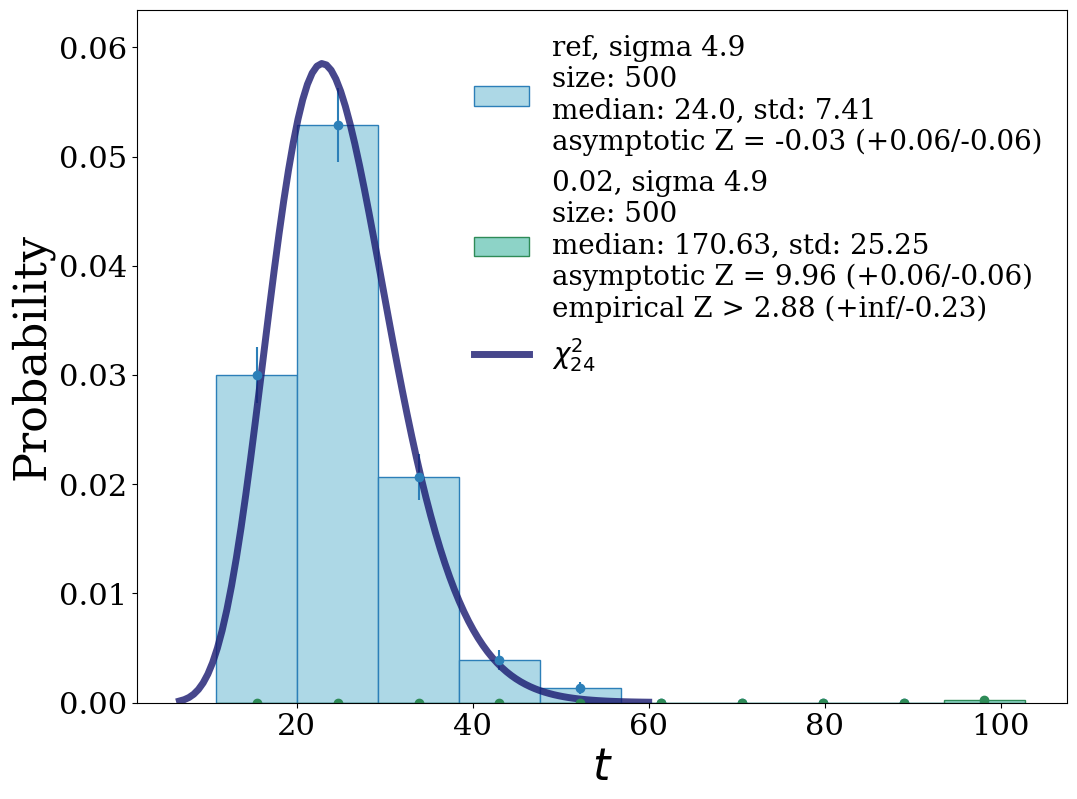

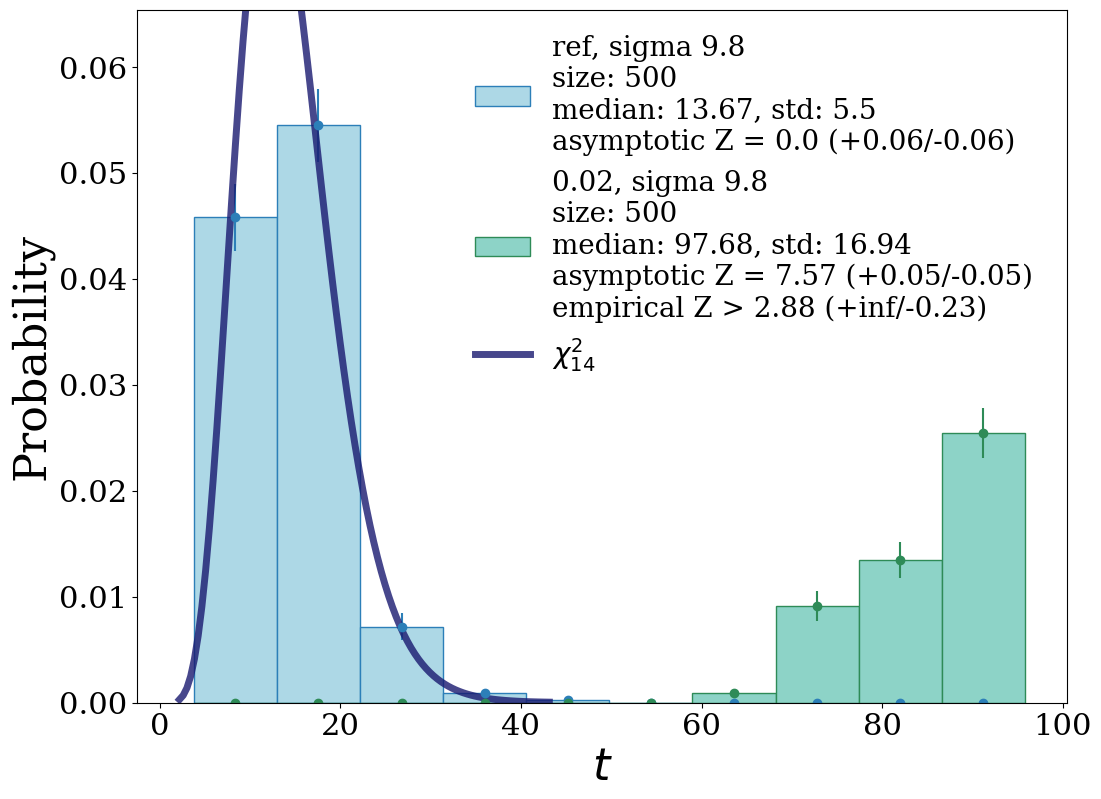

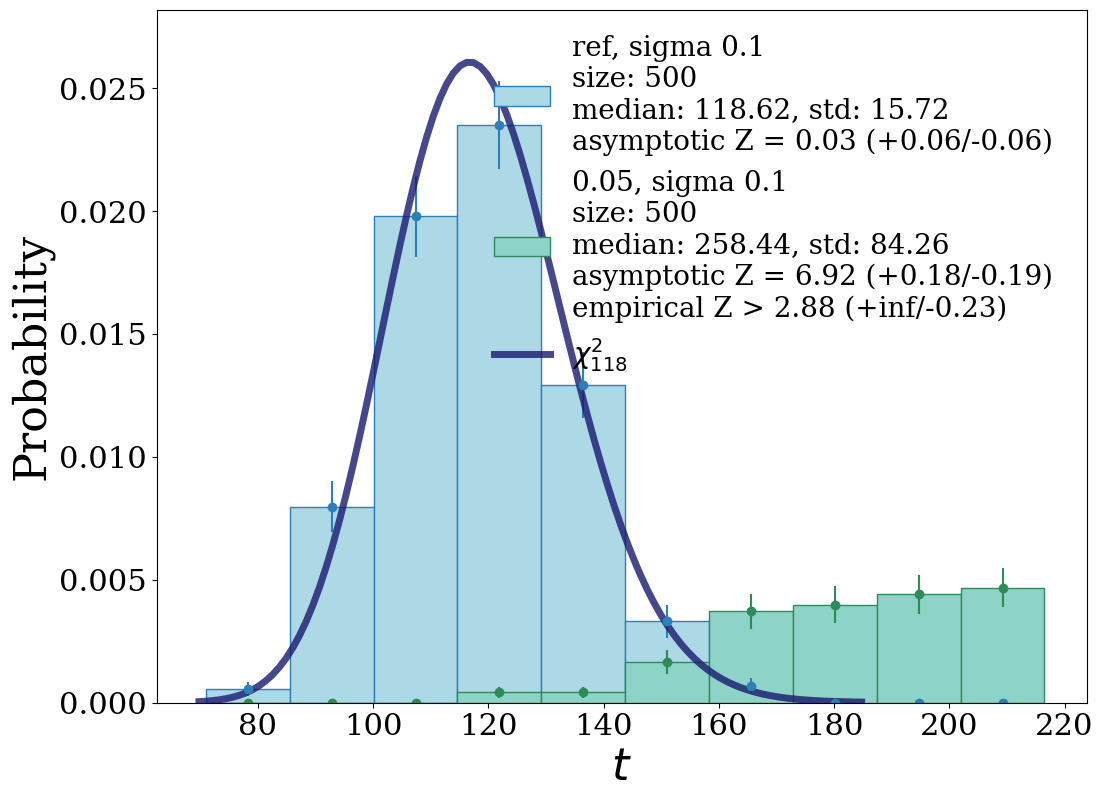

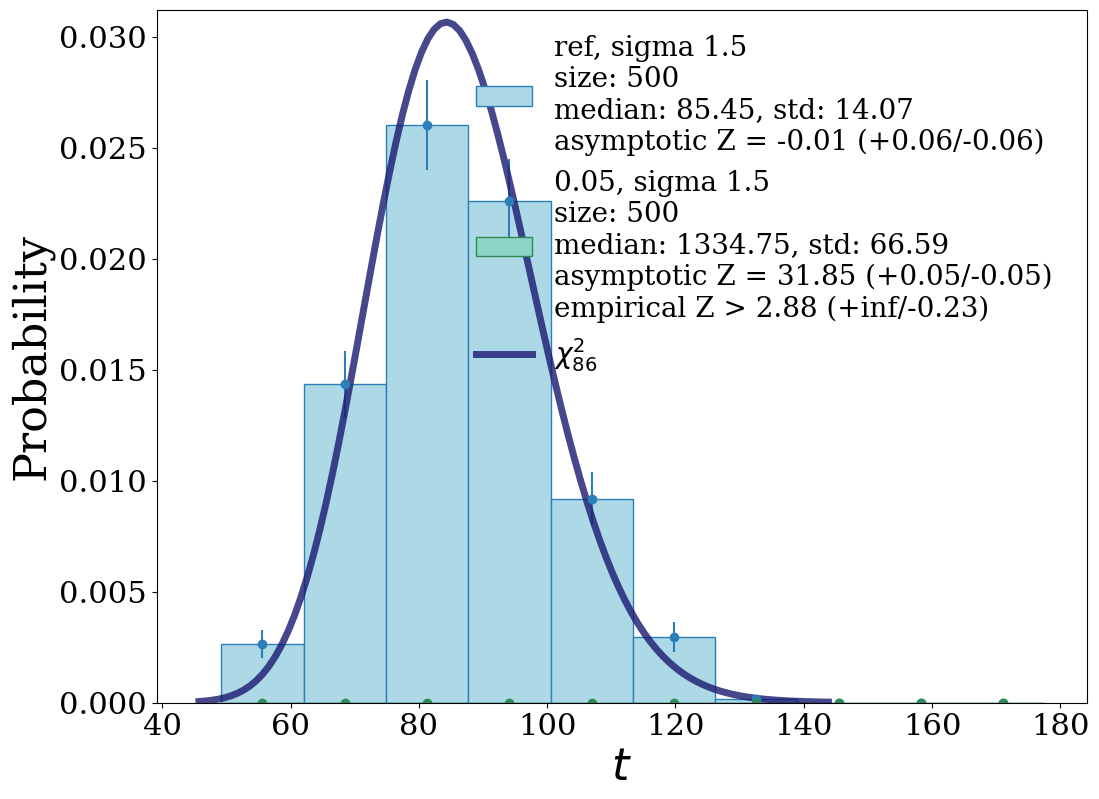

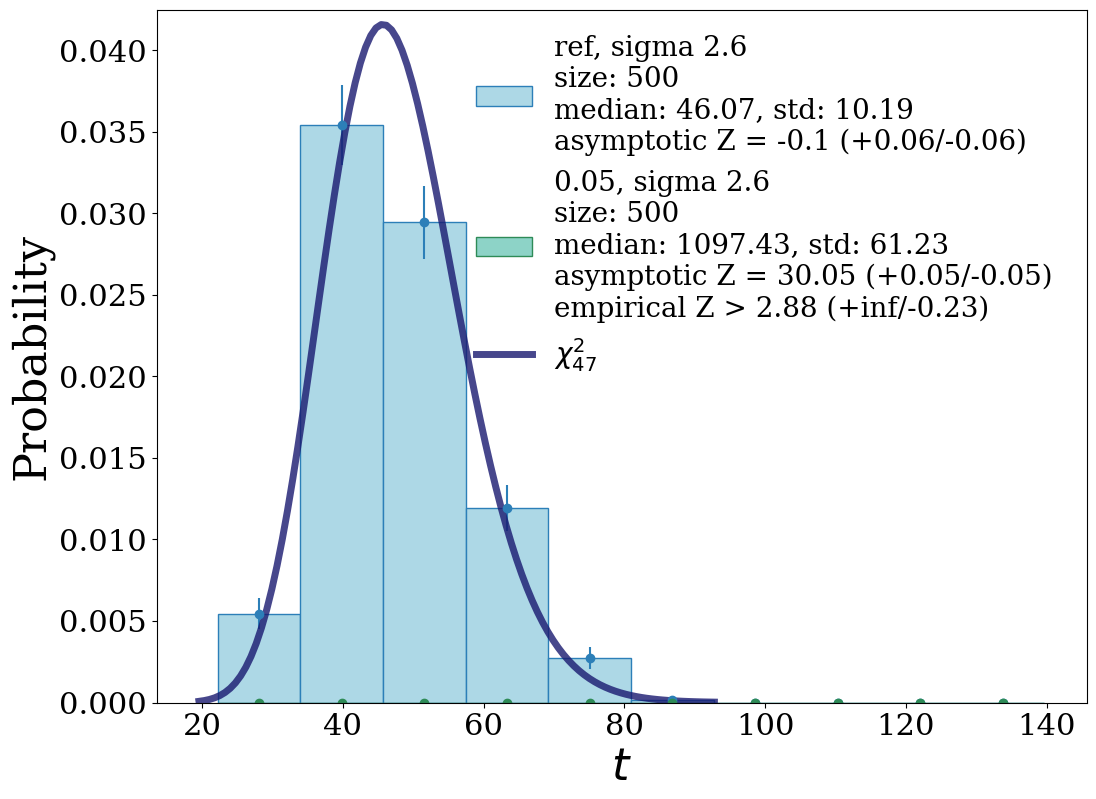

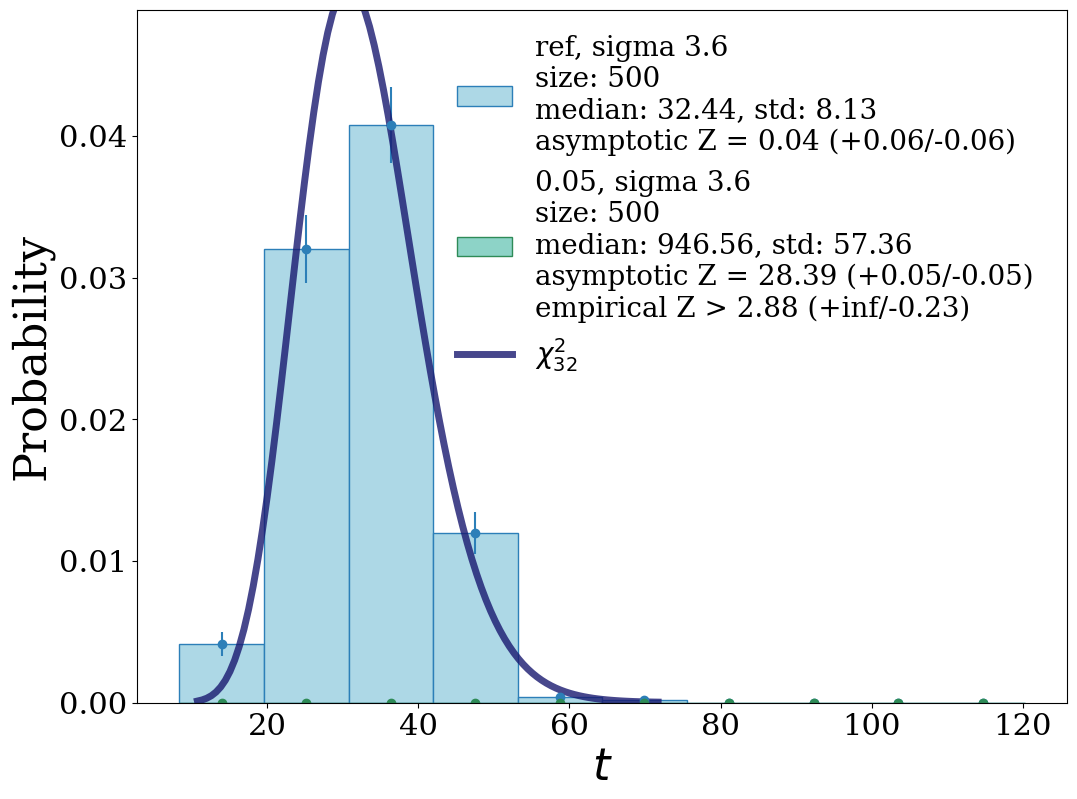

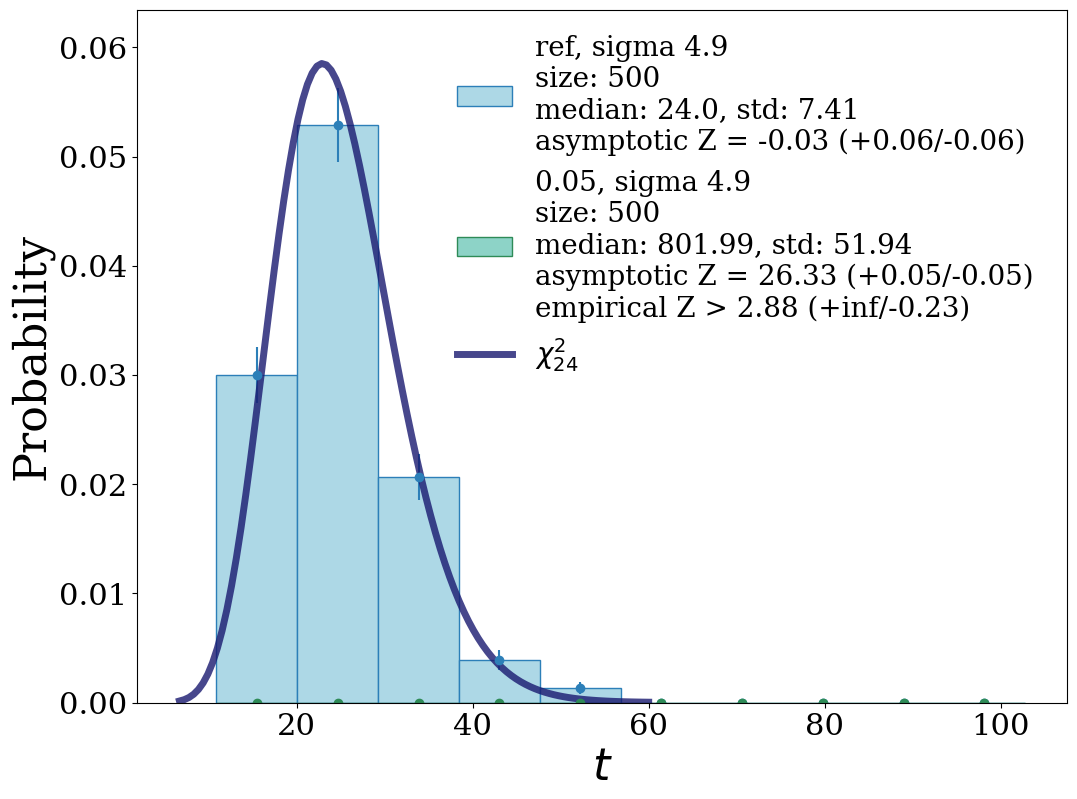

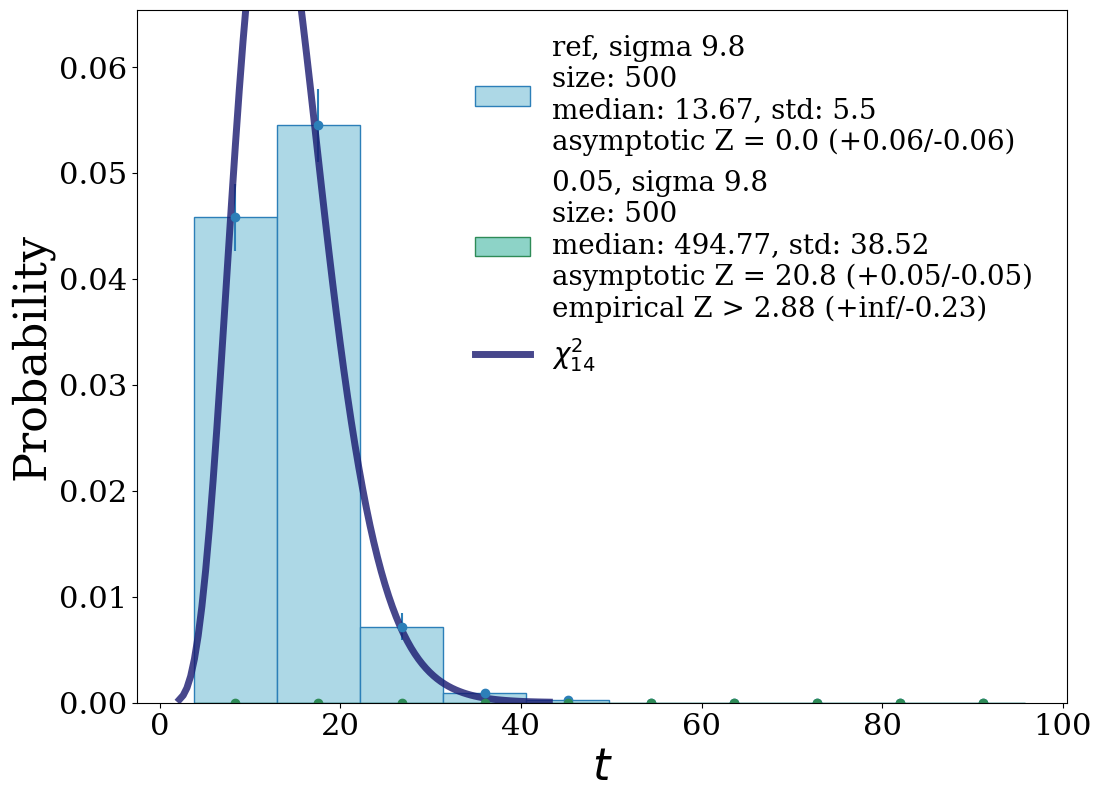

In [9]:
NTOYS = 500

tstat_dict = {}
i=0
for f5 in files:
    f = h5py.File(f5, 'r')
    if not len(flk_sigmas):
        flk_sigmas = list(f.keys())
    tstat_dict[labels_list[i]] = []
    for flk_sigma in flk_sigmas:
        key = str(flk_sigma) 
        tstat_dict[labels_list[i]].append(np.array(f[key])[:NTOYS].reshape(-1,1))
    tstat_dict[labels_list[i]] = np.concatenate(tstat_dict[labels_list[i]],axis=1)
    f.close()
    i+=1

i=0
for key in list(tstat_dict.keys()):
    for isigma,flk_sigma in enumerate(flk_sigmas):
        t1 = tstat_dict['ref'][:,isigma]
        t1[np.isnan(t1)]=np.zeros_like(t1[np.isnan(t1)])
        
        t2 = tstat_dict[key][:,isigma]
        t2[np.isnan(t2)]=np.zeros_like(t2[np.isnan(t2)])
        
        plot_2distribution(t1,t2,df=np.mean(t1),xmin=t1.min(),label1=f'ref, sigma {flk_sigma}',label2=f'{key}, sigma {flk_sigma}',xmax=t1.max()+50,nbins=10)
        
    i+=1

# Visualize Spaces

In [21]:
base_dir = "/".join(files_dict[0.1].split("/")[:-1])
with open(f"{base_dir}/config.json","r") as fin:
    config = json.load(fin)

ref_data = np.load(config['ref_filepath'])
bkg_data = np.load(config['data_filepath'])
anom_label = config['anomaly_label']

ref_mask = ref_data['labels'] != anom_label
bkg_mask = bkg_data['labels'] != anom_label

ref = ref_data['data'][ref_mask]
ref_labels = ref_data['labels'][ref_mask]
bkg = bkg_data['data'][bkg_mask]
bkg_labels = bkg_data['labels'][bkg_mask]
anom = bkg_data['data'][~bkg_mask]
anom_labels = bkg_data['labels'][~bkg_mask]

In [19]:
import umap
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(ref)
reducer = umap.UMAP(n_neighbors=10, n_components=2, min_dist=0.1, random_state=42)

all_data = np.concatenate([scaler.transform(bkg),scaler.transform(anom)],axis=0)
all_labels = np.concatenate([bkg_labels,np.zeros(len(anom))],axis=0)
red_data = reducer.fit_transform(all_data)

/n/holystore01/LABS/iaifi_lab/Users/sambt/mamba/envs/torch_gpu/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


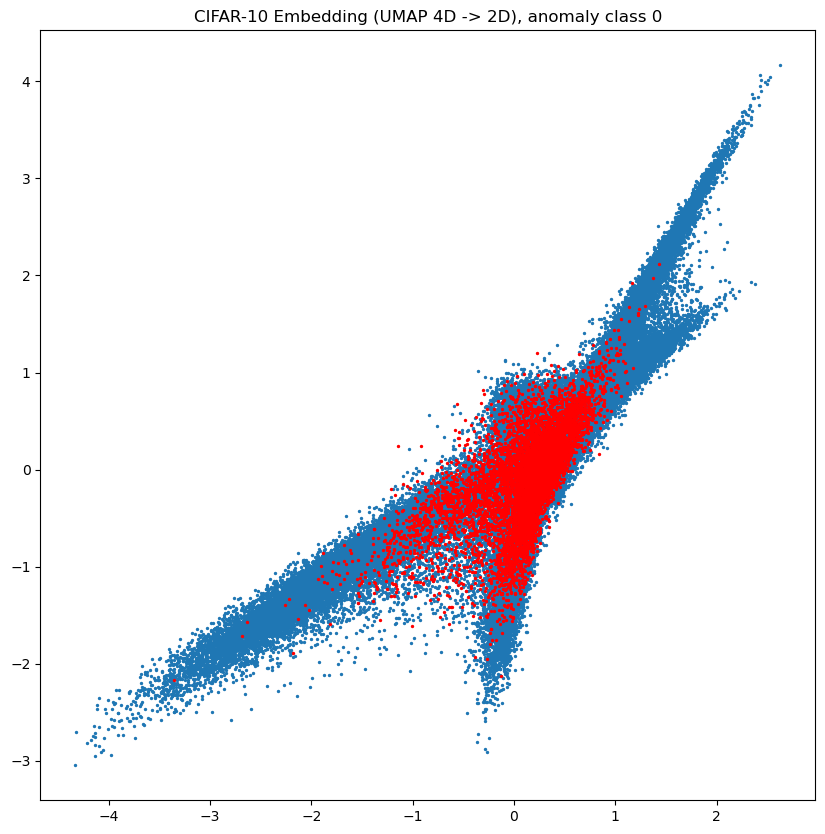

In [20]:
plt.figure(figsize=(10,10))
plt.title("CIFAR-10 Embedding (UMAP 4D -> 2D), anomaly class 0")
plt.scatter(all_data[all_labels != 0][:,0],all_data[all_labels != 0][:,1],color="C0",s=2)
plt.scatter(all_data[all_labels == 0][:,0],all_data[all_labels == 0][:,1],color="r",s=2)

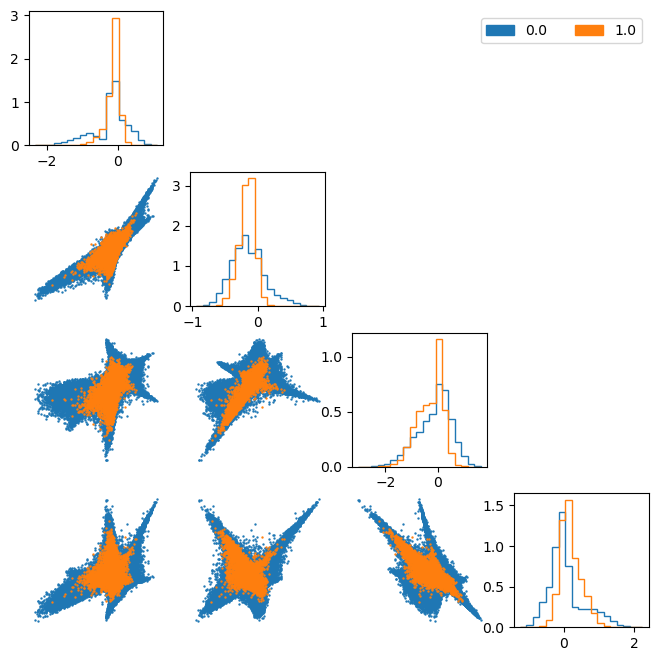

In [24]:
make_corner(np.concatenate([bkg,anom]),labels=np.concatenate([np.zeros(len(bkg_labels)),np.ones(len(anom_labels))]))